In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


<IPython.core.display.Javascript object>

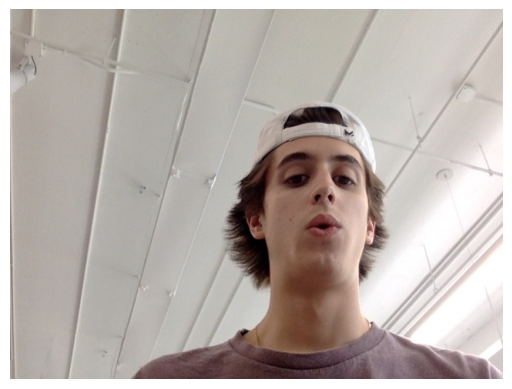

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Capture the photo
photo_filename = take_photo()

# Display the photo
img = mpimg.imread(photo_filename)
plt.imshow(img)
plt.axis('off')  # to hide the axis values
plt.show()

In [3]:
img.shape

(480, 640, 3)

In [4]:
import torch
from torchvision import models, transforms
import requests
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#define alexnet model
alexnet = models.alexnet(pretrained=True).to(device)
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

#transform image for use in model
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 31.9MB/s]


In [5]:
img = Image.fromarray(img)

In [6]:
img_t = preprocess(img).unsqueeze_(0).to(device)

In [9]:
def scale(img):
    # Normalize the NumPy array to the range [0, 1]
    max_value = img.max()
    min_value = img.min()
    normalized_array = (img - min_value) / (max_value - min_value)
    return normalized_array

In [10]:
def tensor_plot(img_t,index=0):
    numpy_array = img_t[index,:,:,:].cpu().numpy()
    numpy_array_transposed = numpy_array.transpose(1, 2, 0)
    numpy_array_transposed = scale(numpy_array_transposed)
    plt.imshow(numpy_array_transposed)
    plt.show()

In [13]:
w0 = alexnet.features[0].weight.data
w1 = alexnet.features[3].weight.data
w2 = alexnet.features[6].weight.data
w3 = alexnet.features[8].weight.data
w4 = alexnet.features[10].weight.data
w5 = alexnet.classifier[1].weight.data
w6 = alexnet.classifier[4].weight.data
w7 = alexnet.classifier[6].weight.data

In [17]:
f0 = F.conv2d(img_t, w0, stride=4, padding=2)

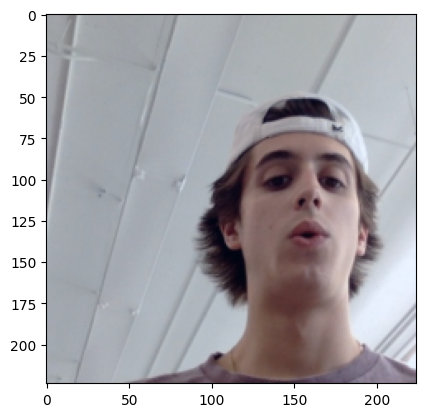

In [11]:
tensor_plot(img_t)

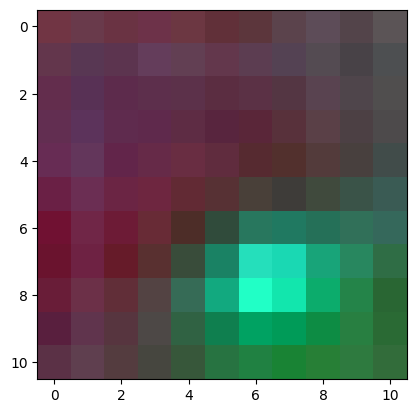

In [14]:
tensor_plot(w0,0)

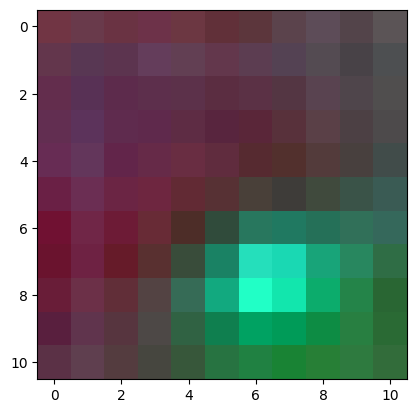

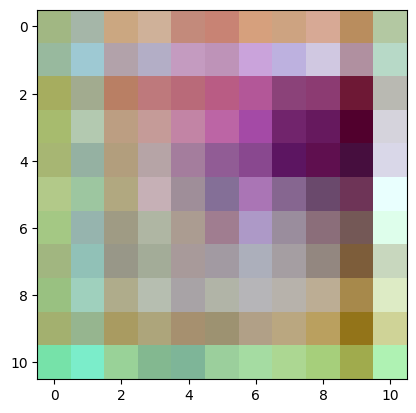

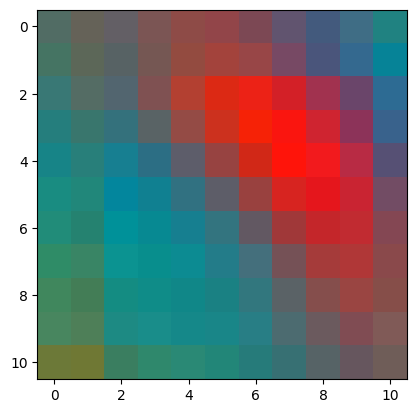

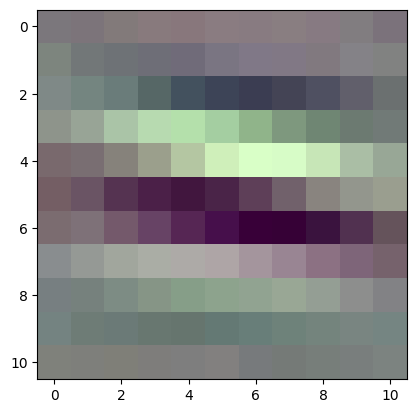

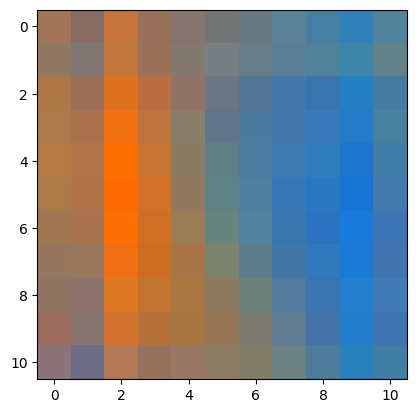

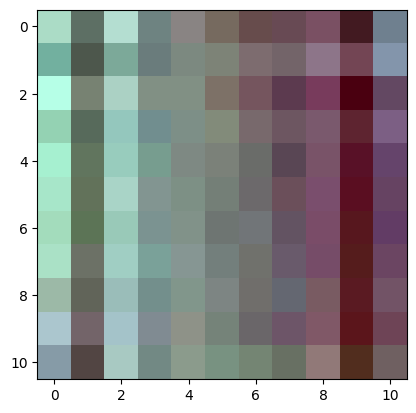

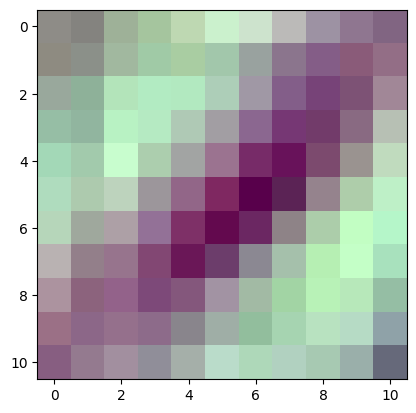

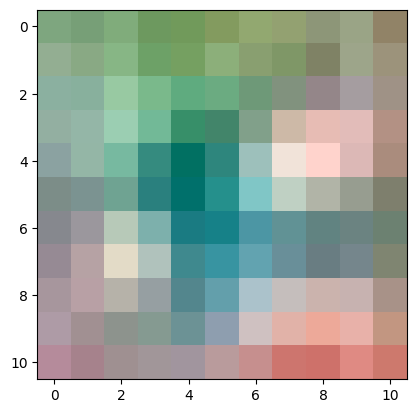

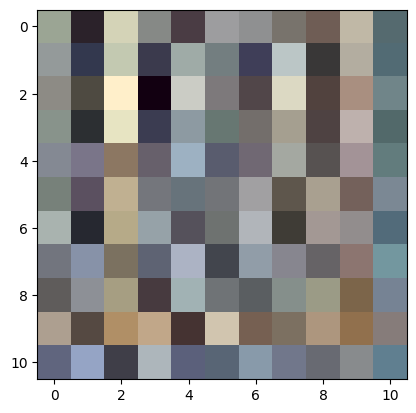

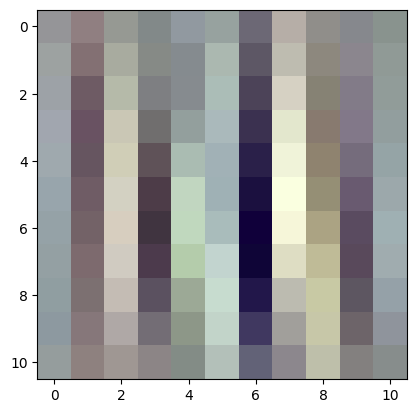

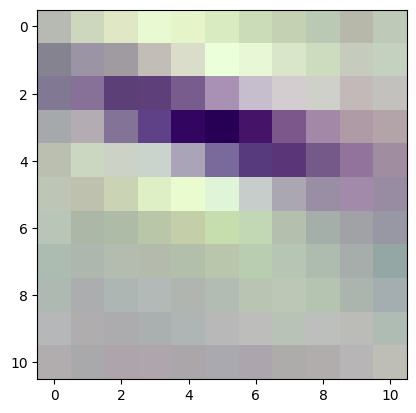

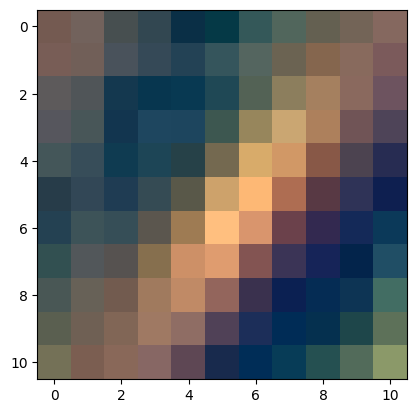

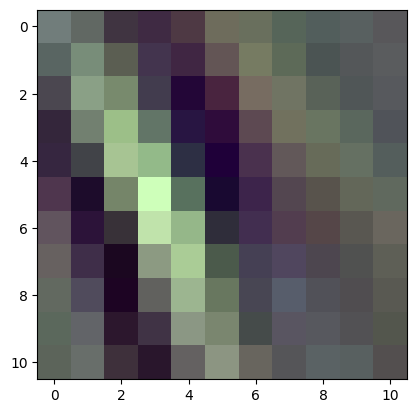

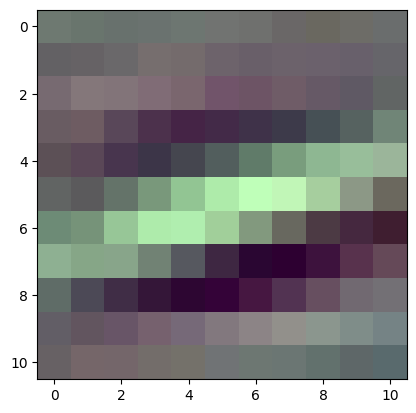

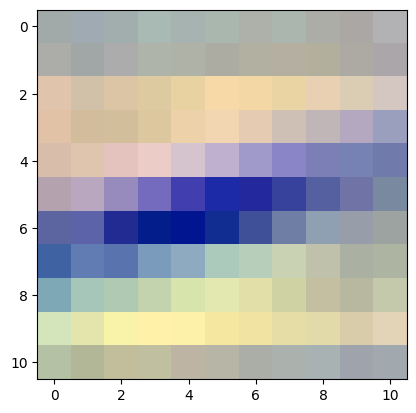

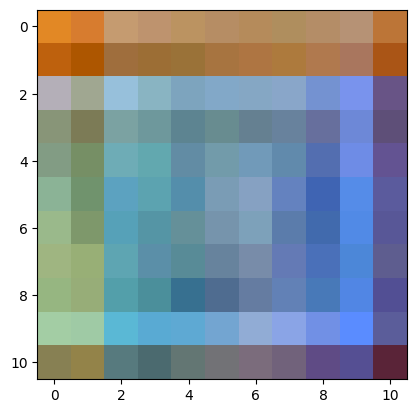

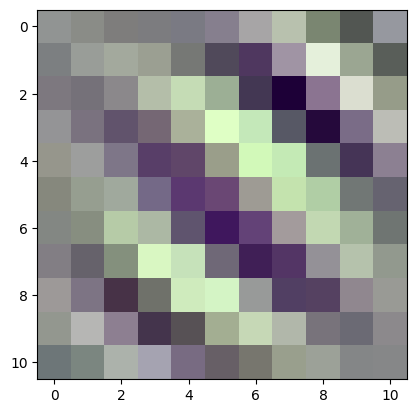

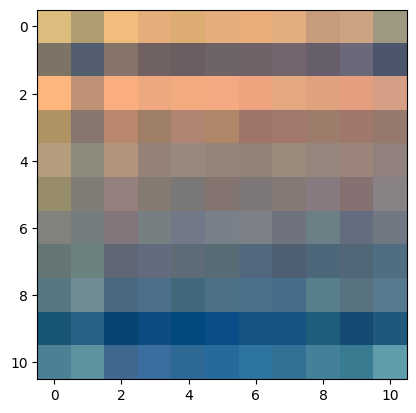

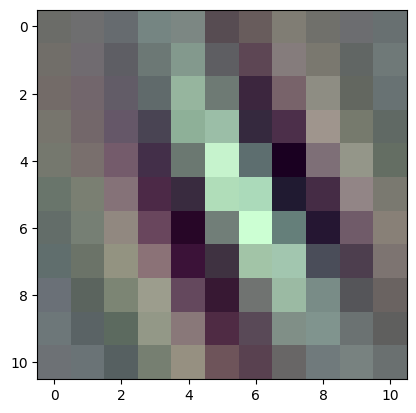

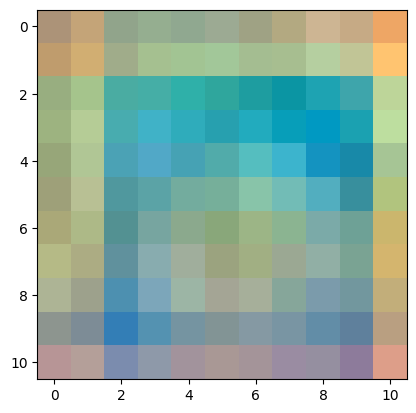

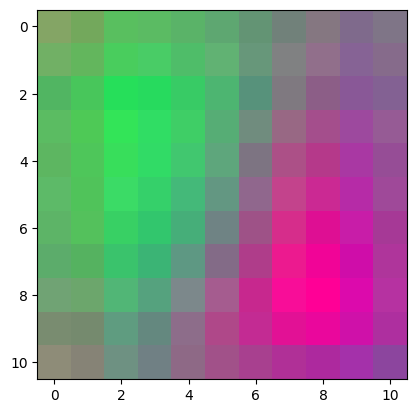

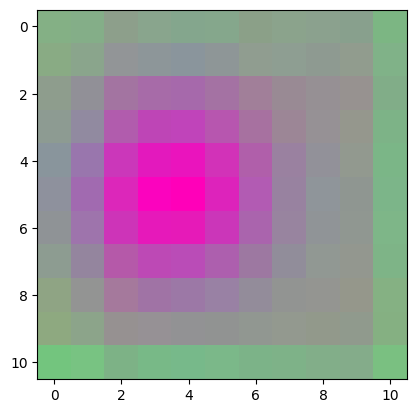

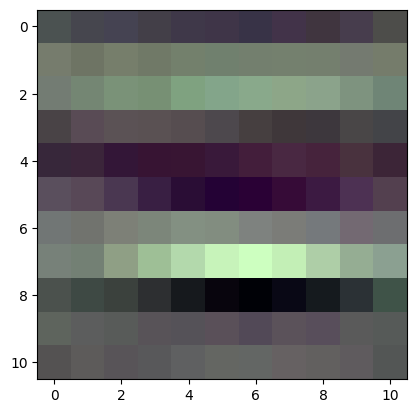

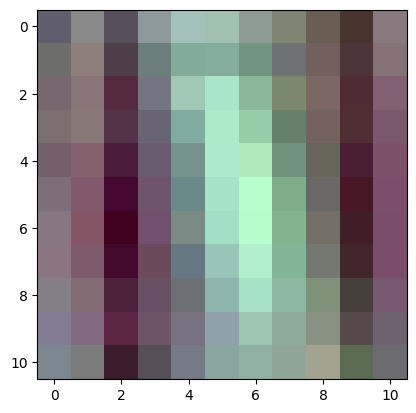

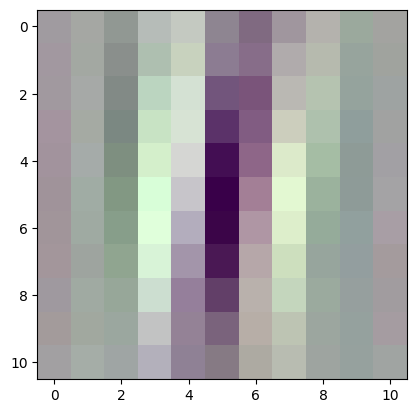

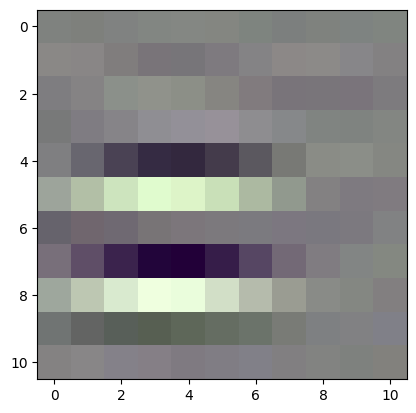

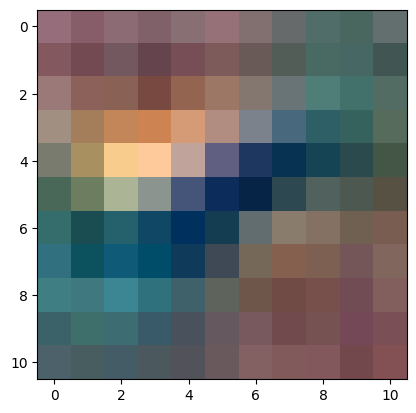

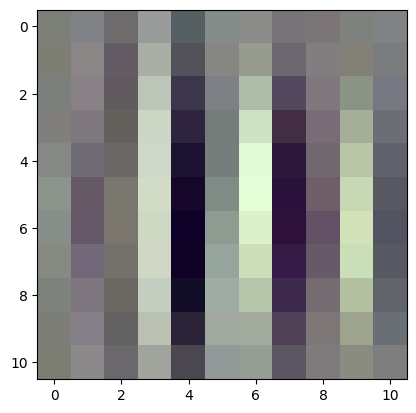

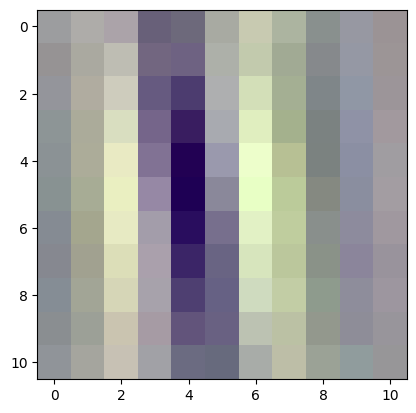

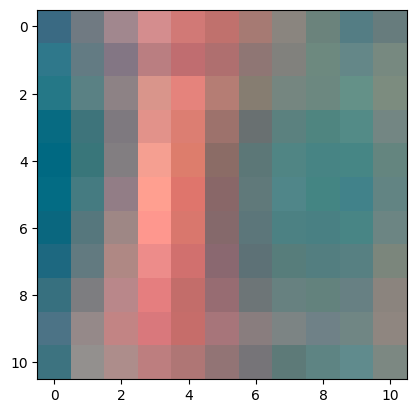

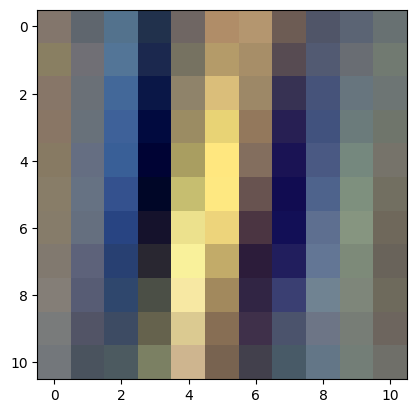

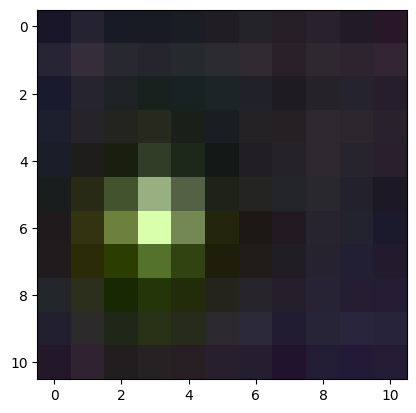

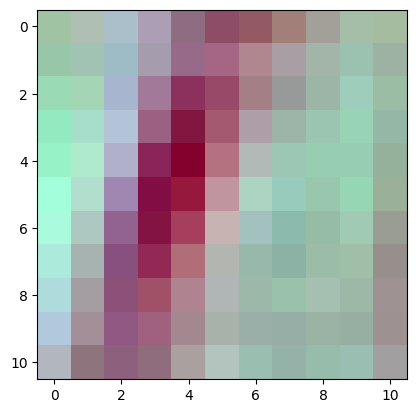

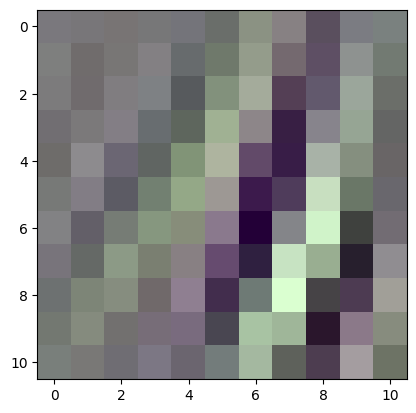

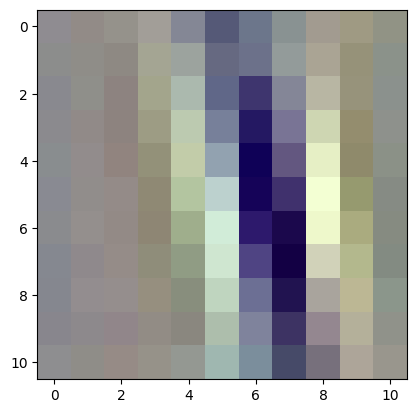

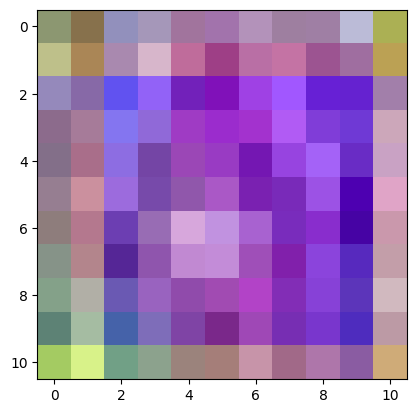

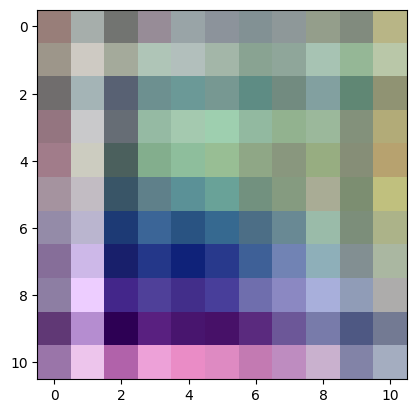

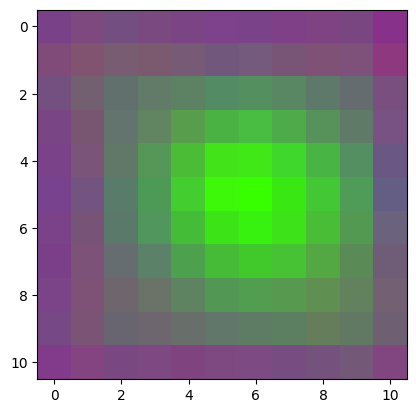

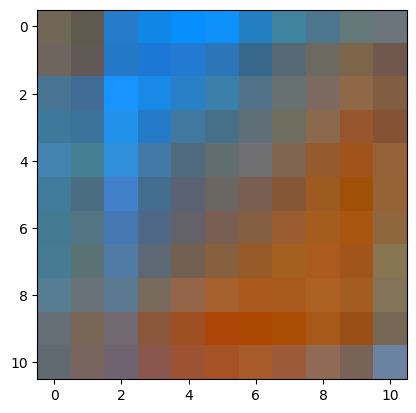

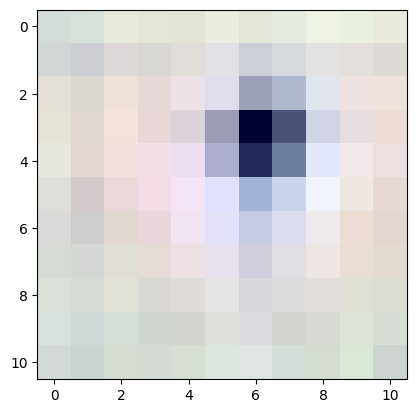

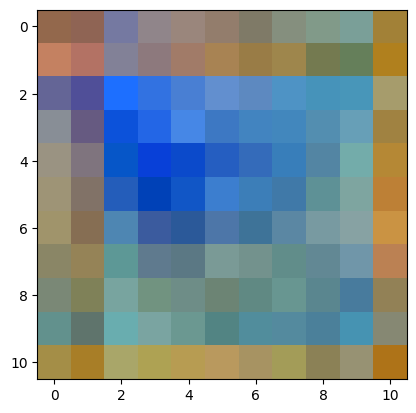

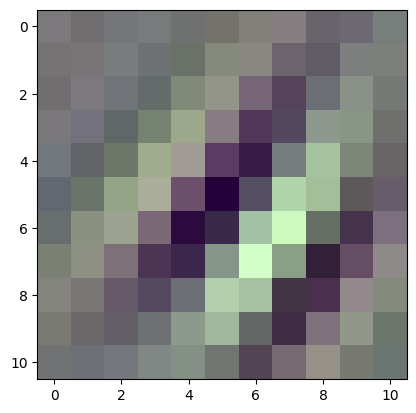

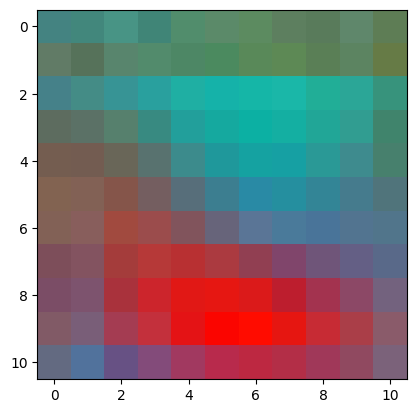

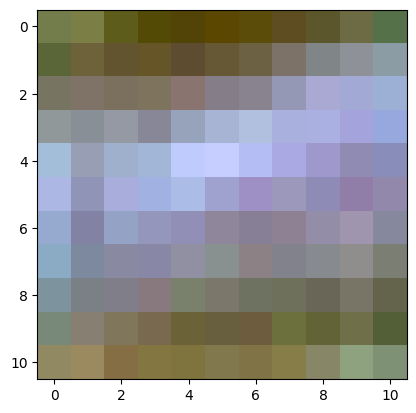

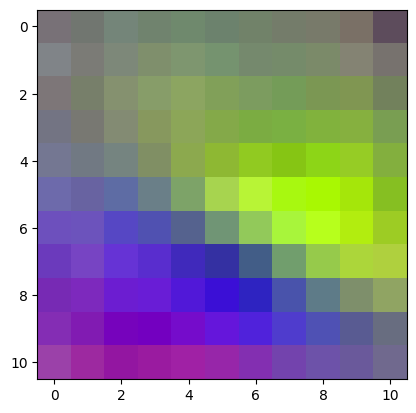

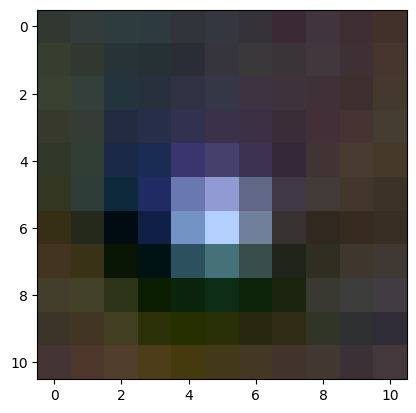

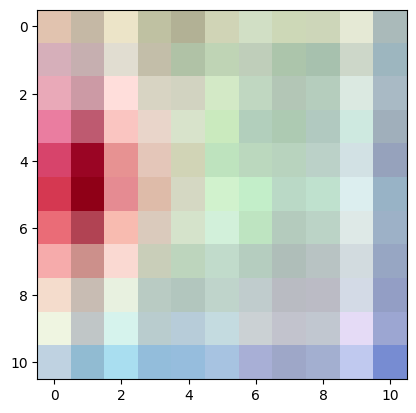

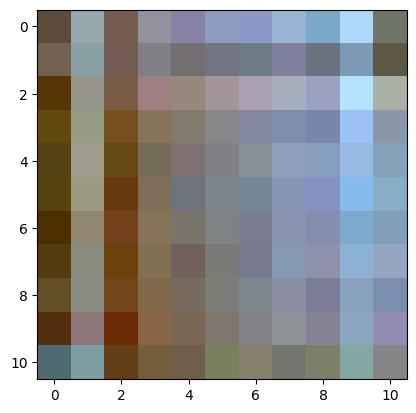

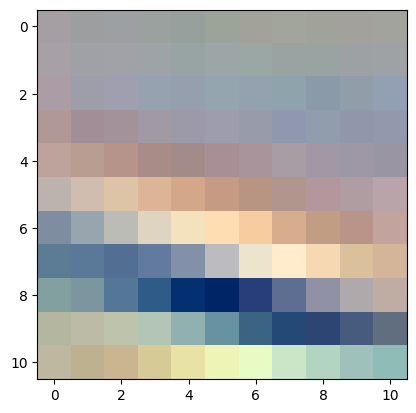

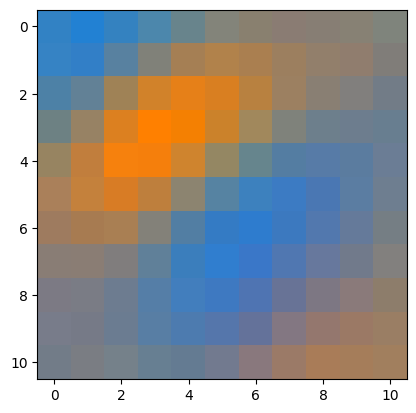

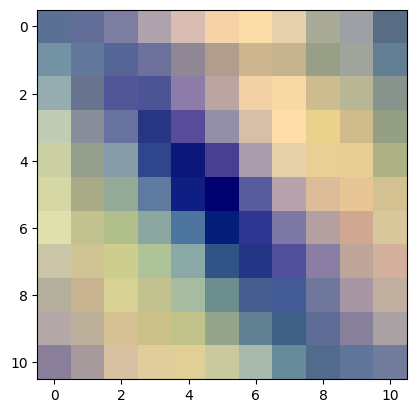

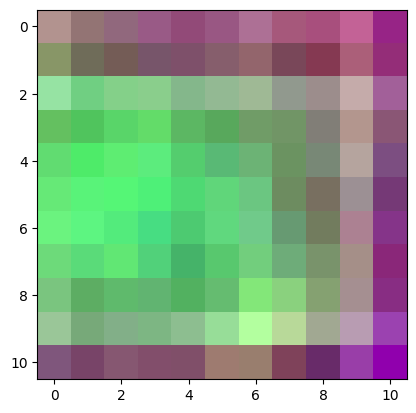

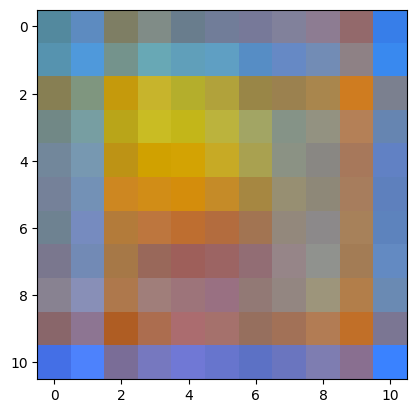

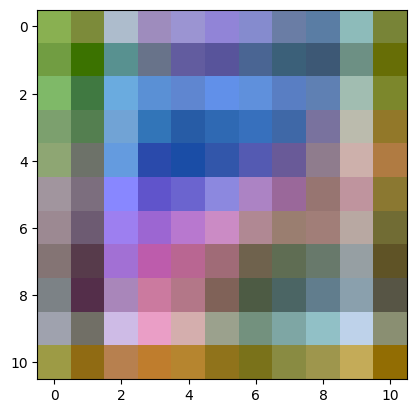

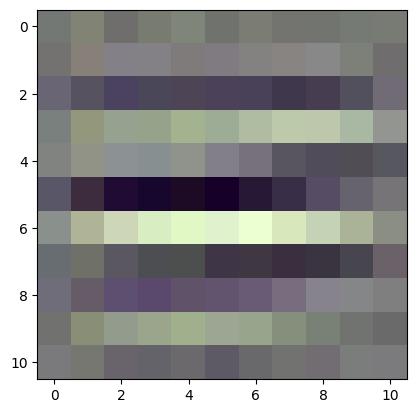

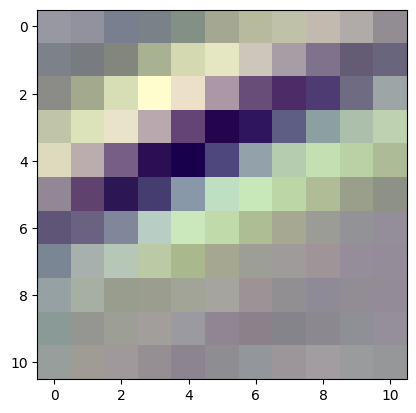

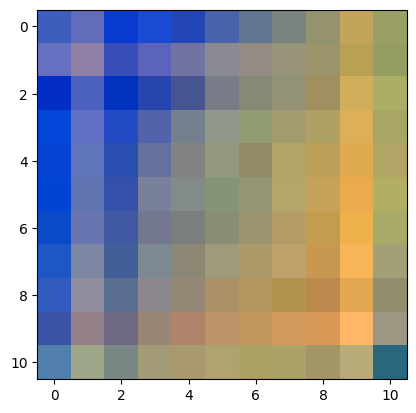

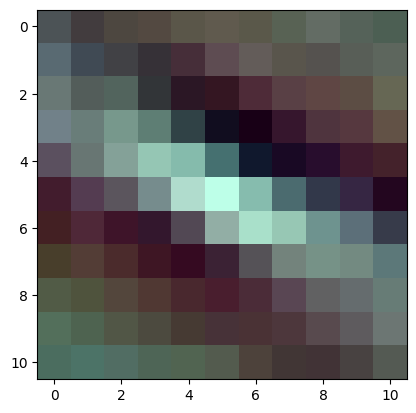

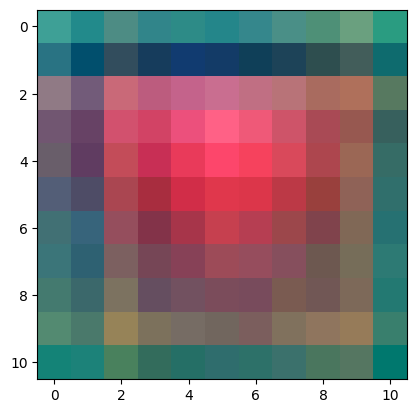

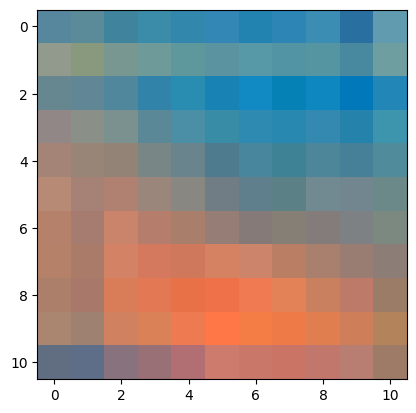

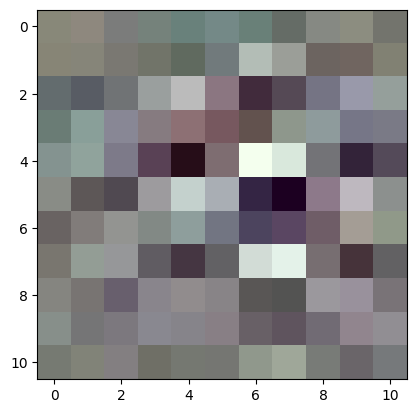

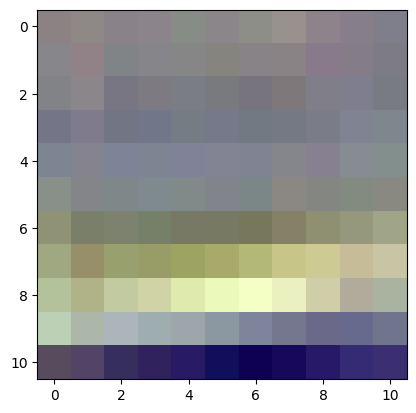

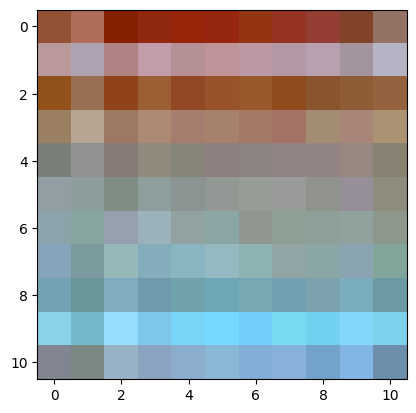

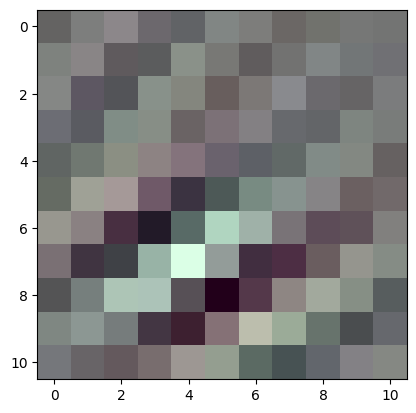

In [15]:
for i in range(64):
    tensor_plot(w0,i)

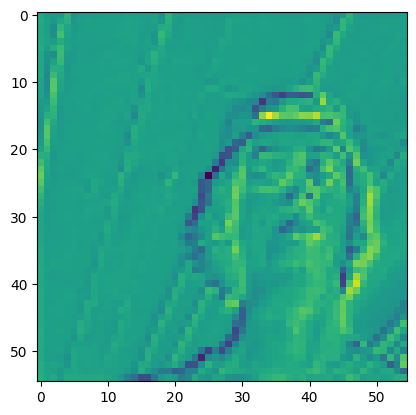

In [18]:
i = 0
plt.imshow(f0[0,i,:,:].cpu().numpy())

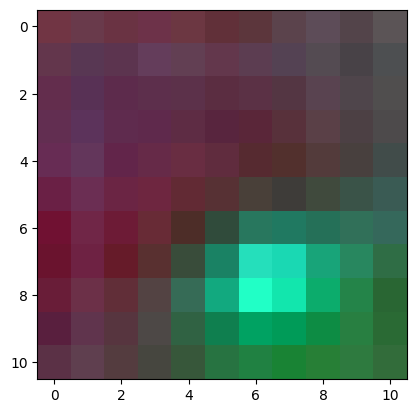

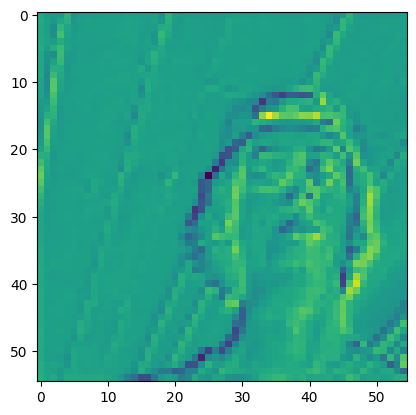

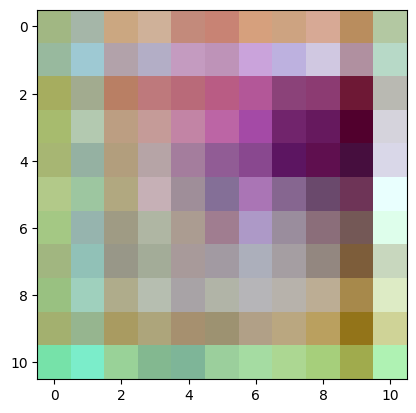

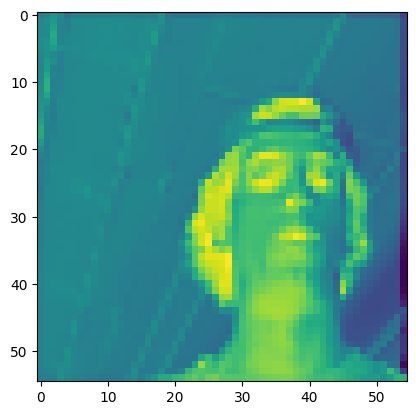

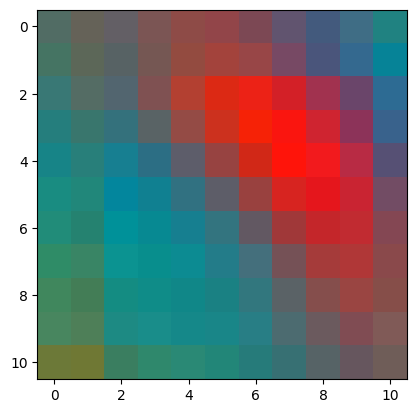

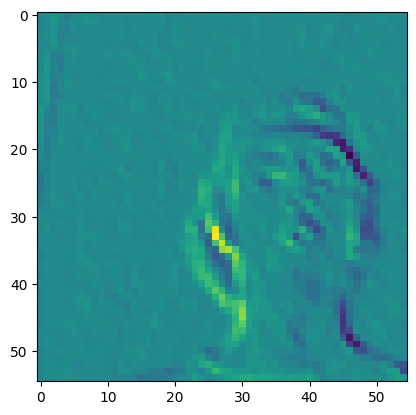

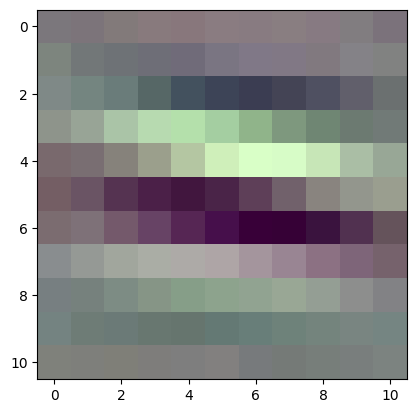

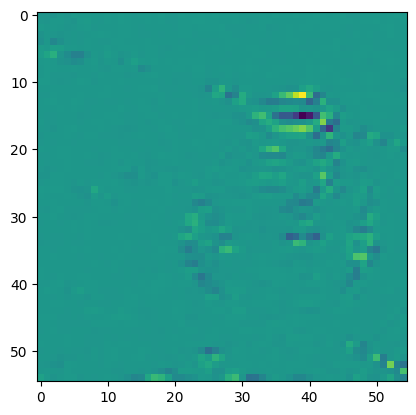

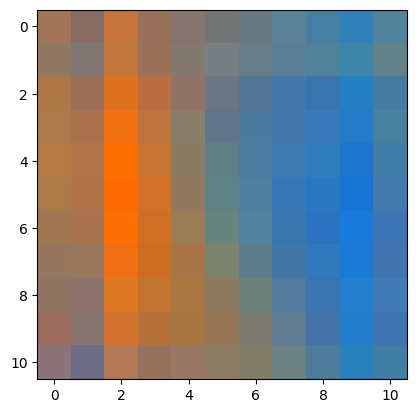

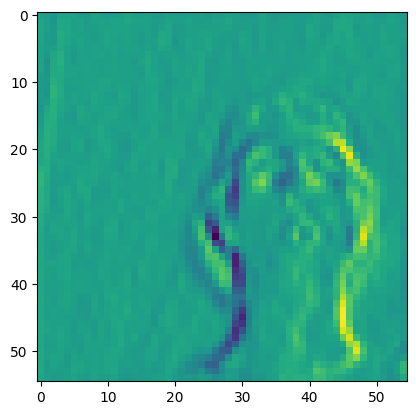

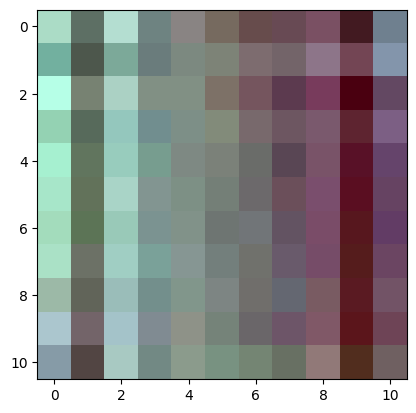

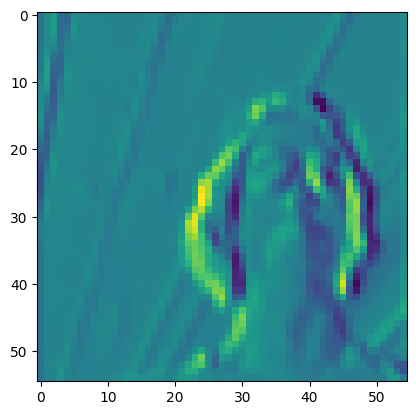

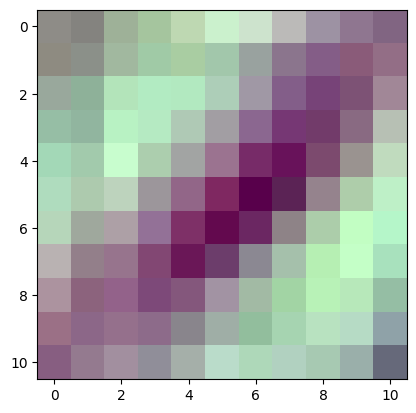

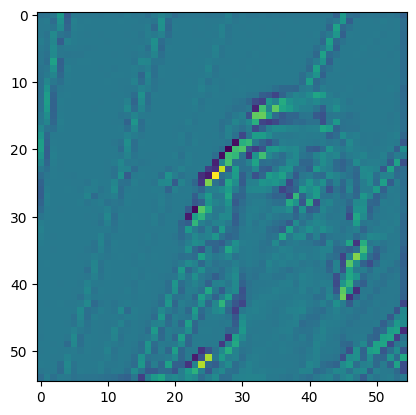

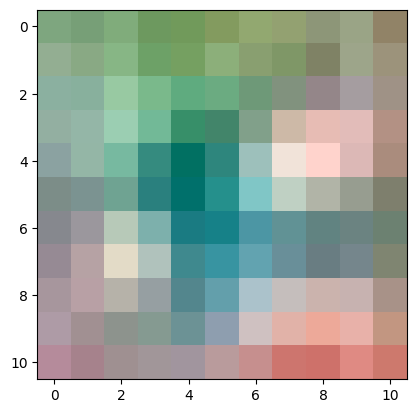

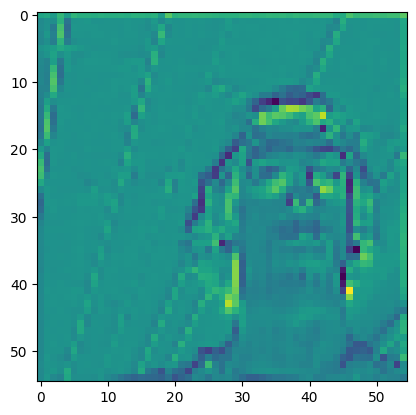

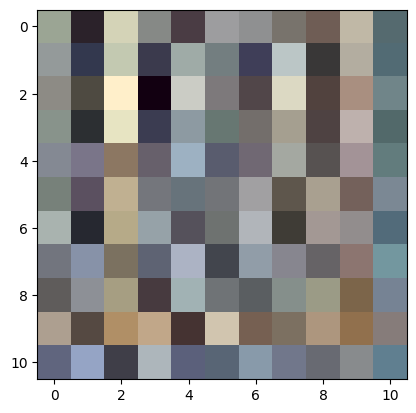

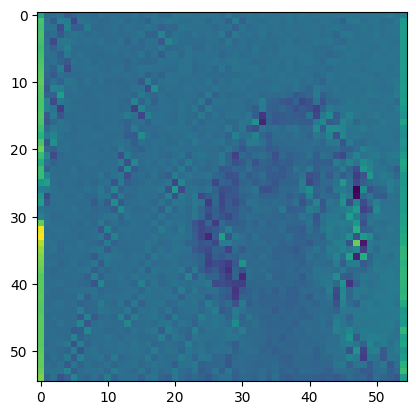

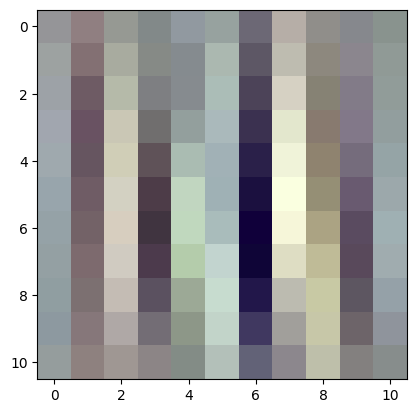

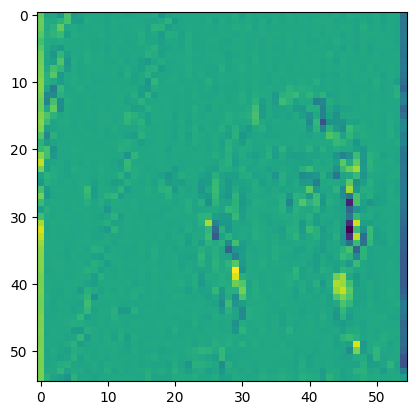

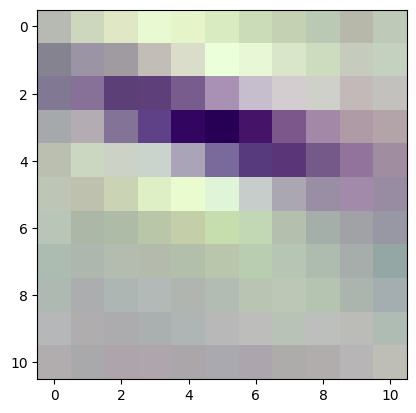

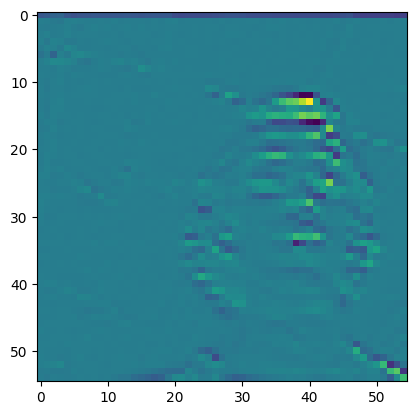

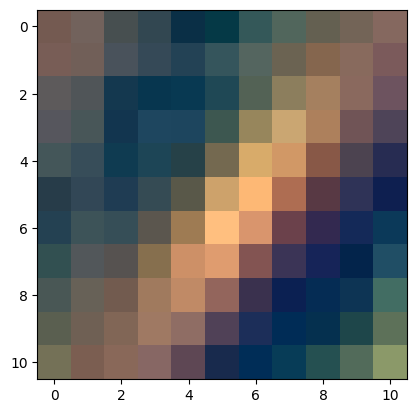

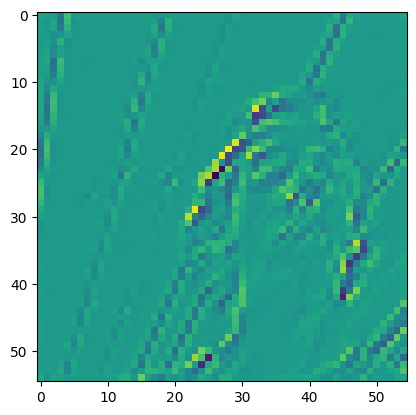

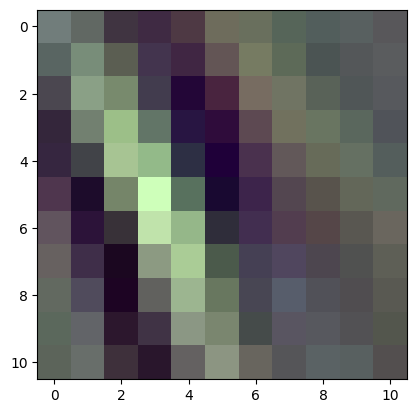

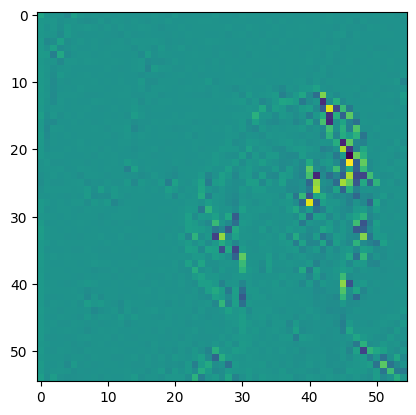

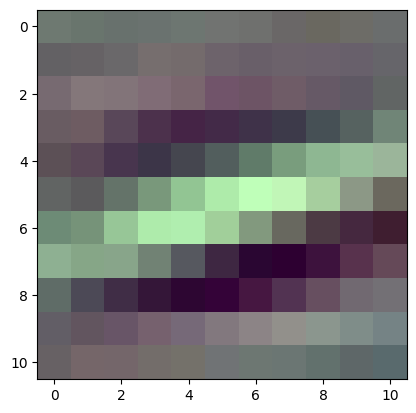

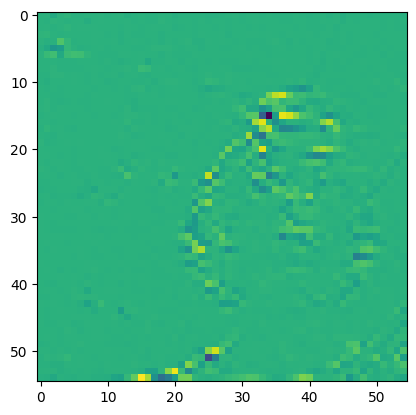

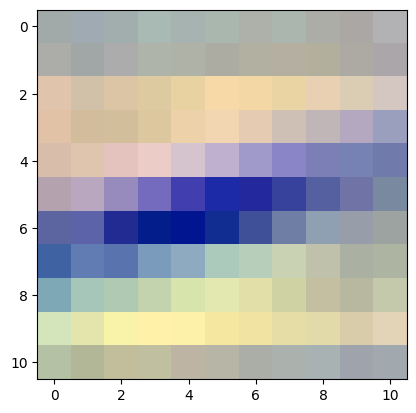

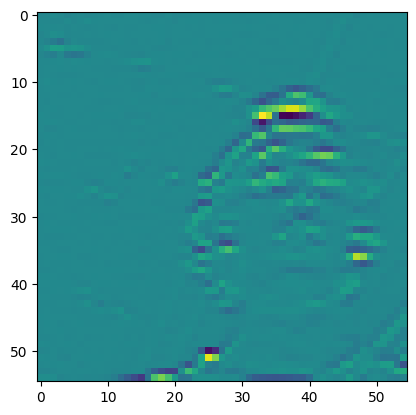

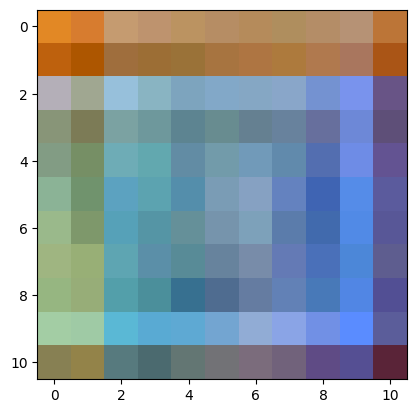

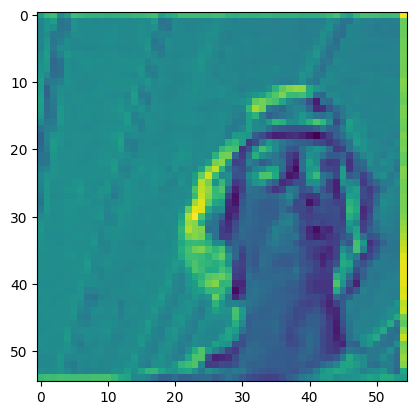

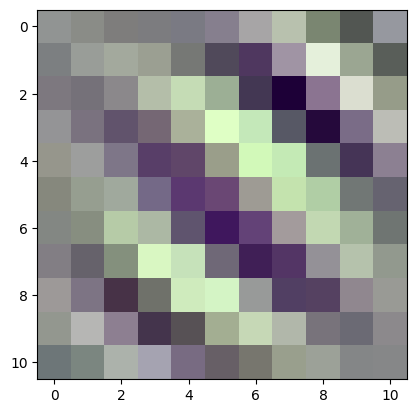

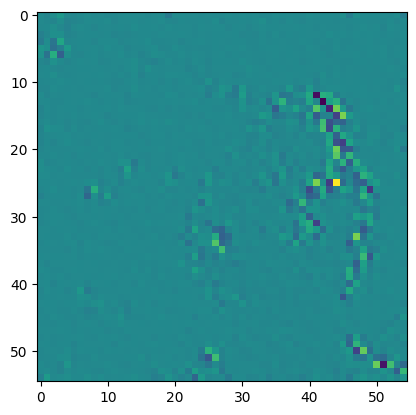

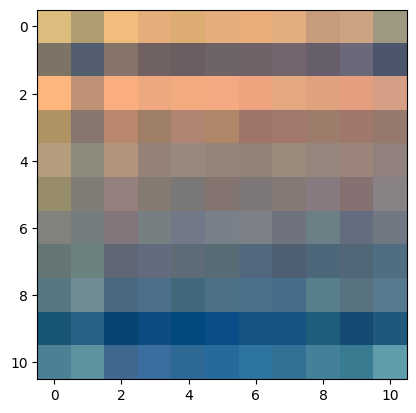

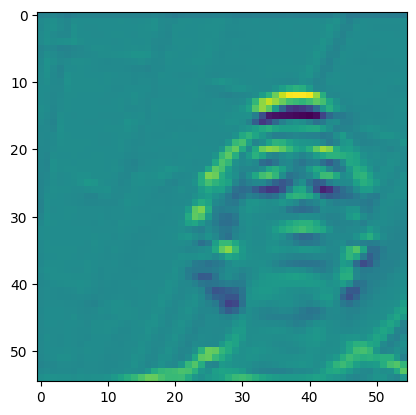

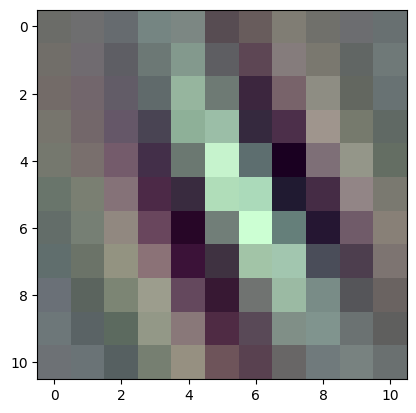

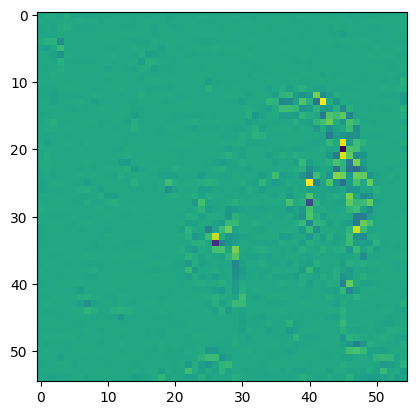

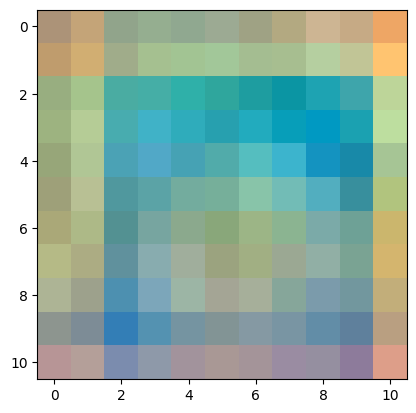

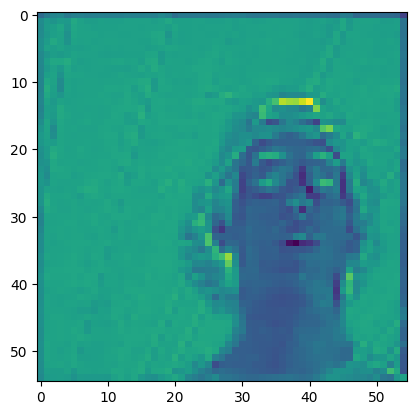

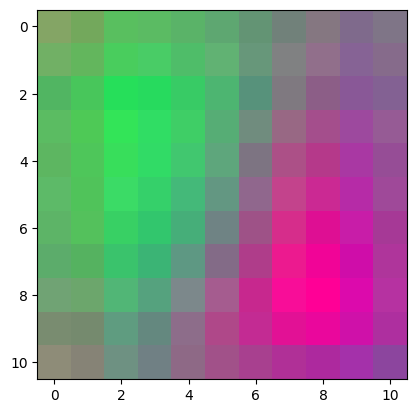

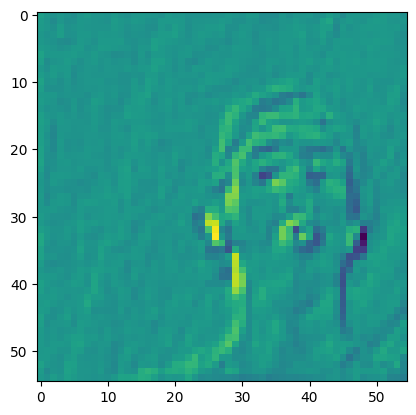

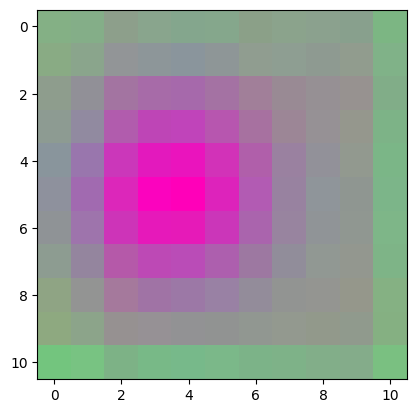

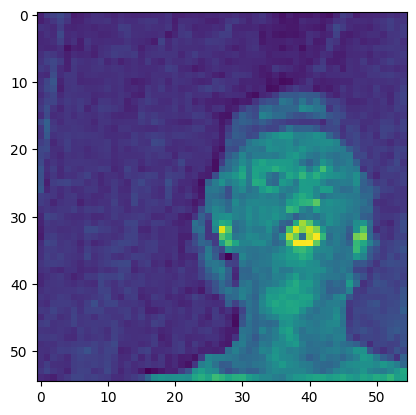

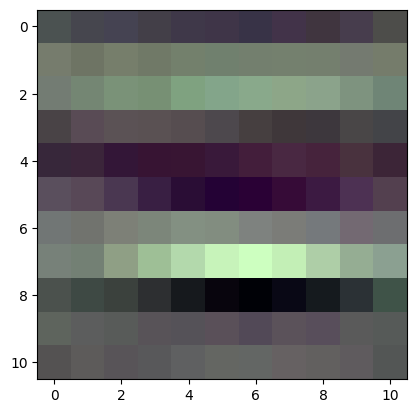

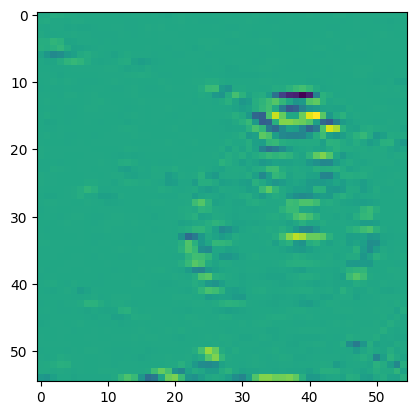

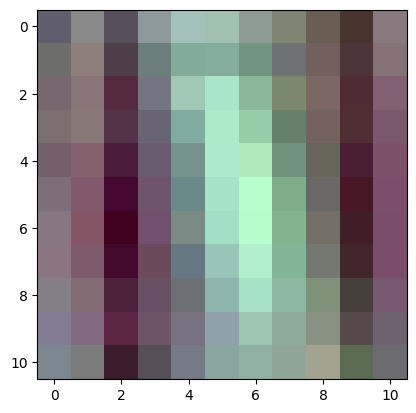

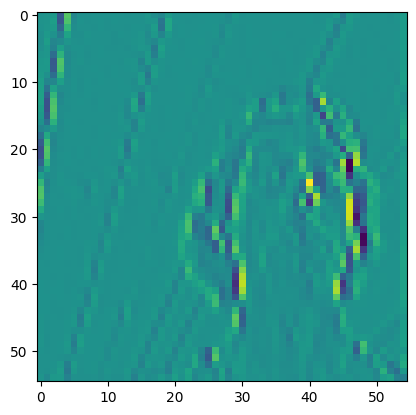

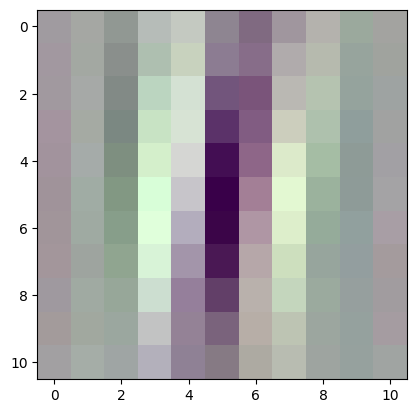

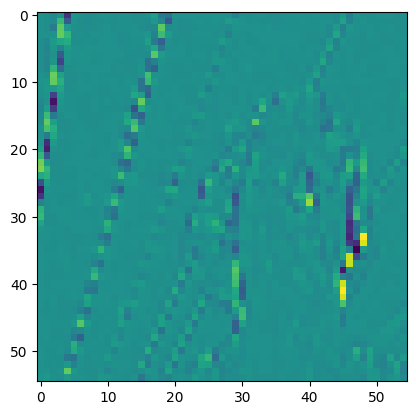

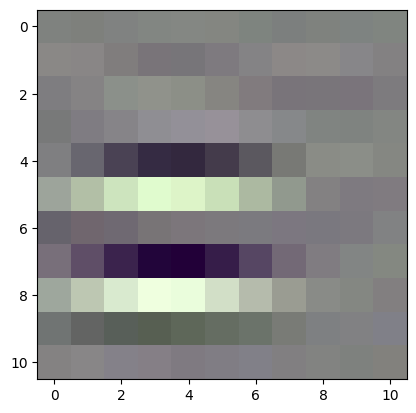

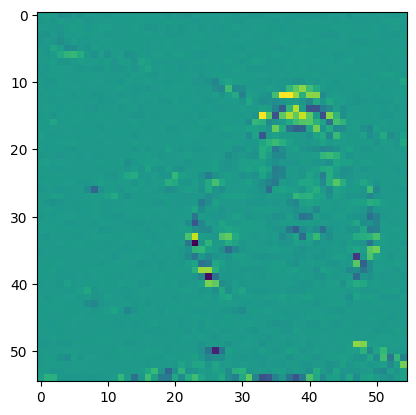

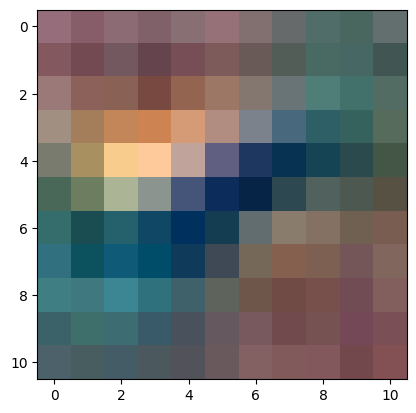

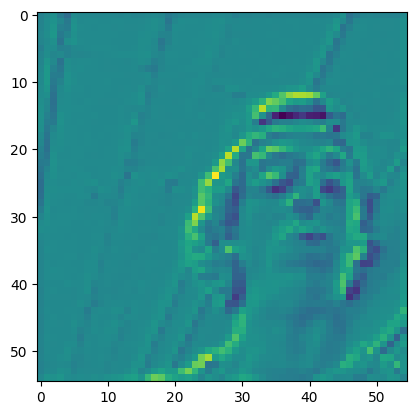

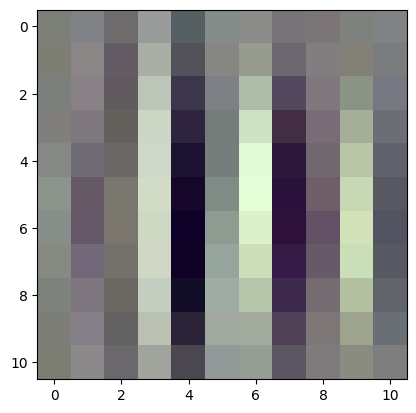

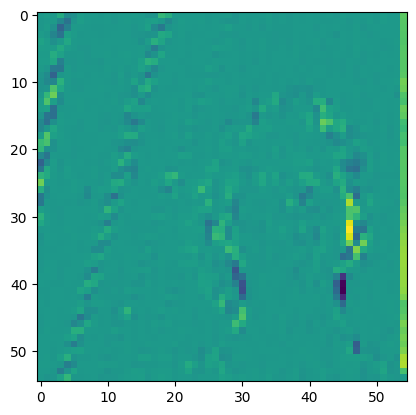

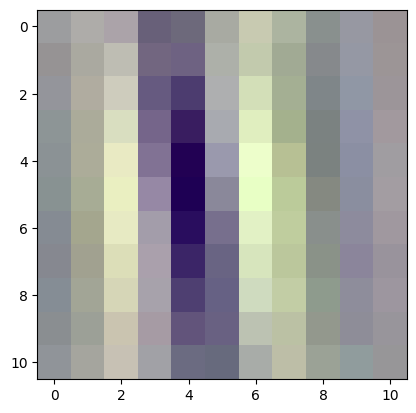

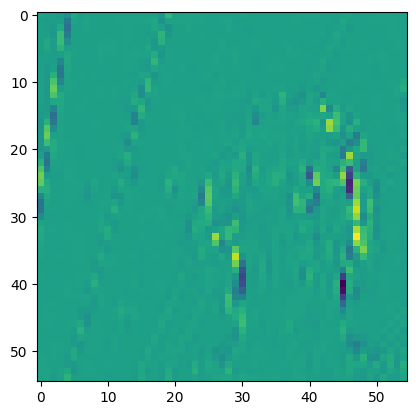

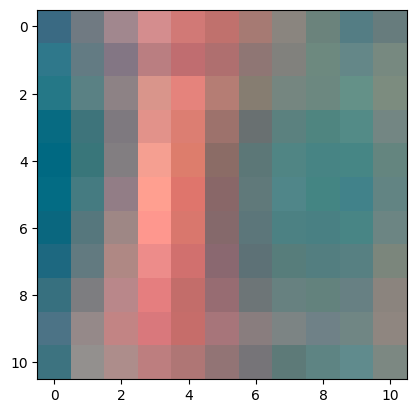

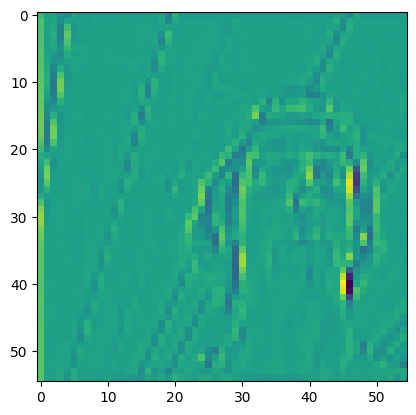

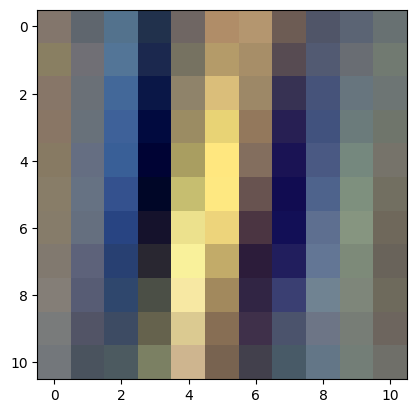

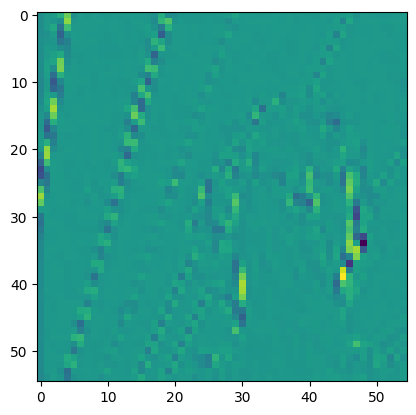

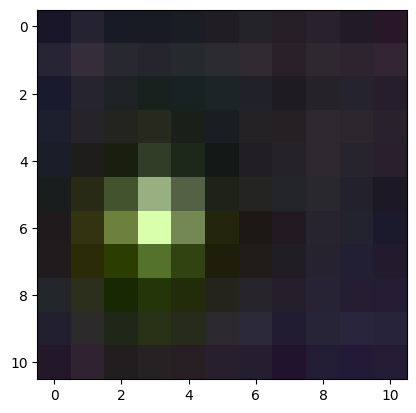

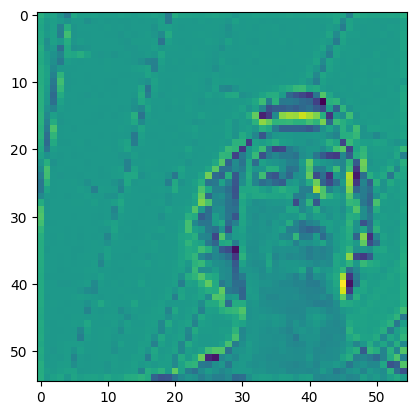

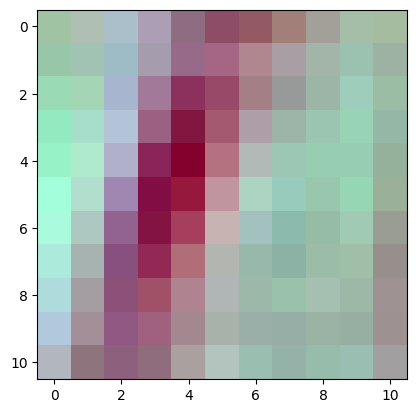

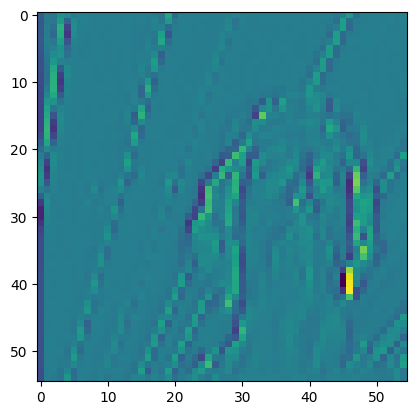

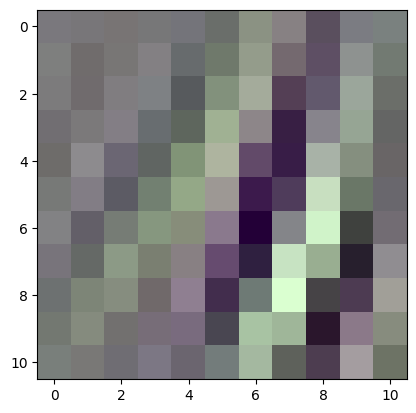

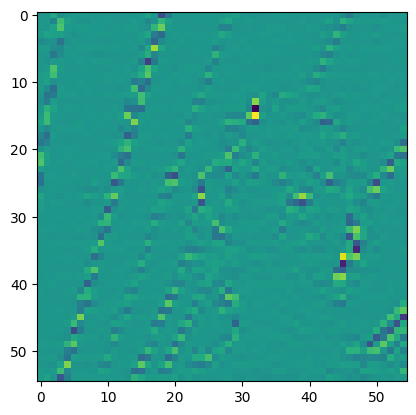

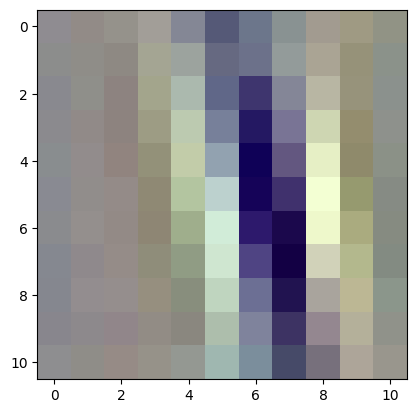

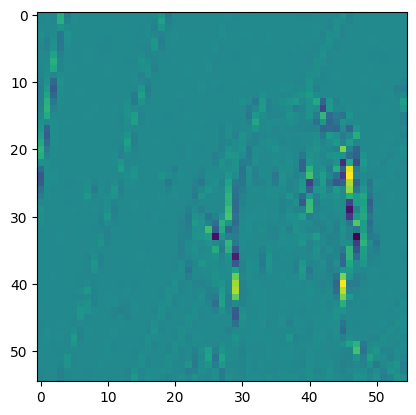

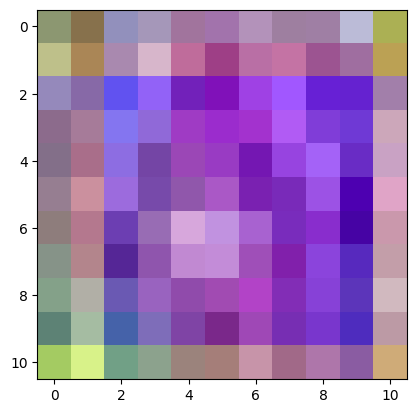

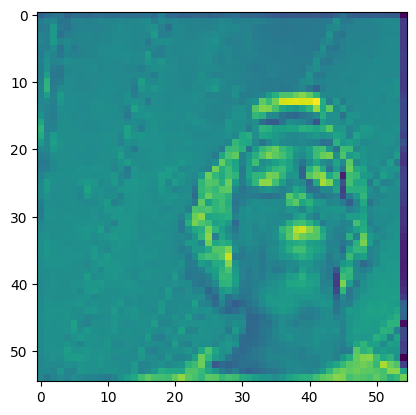

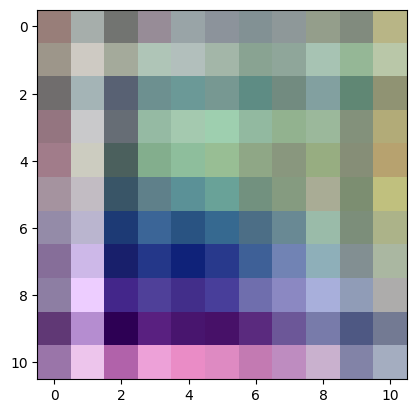

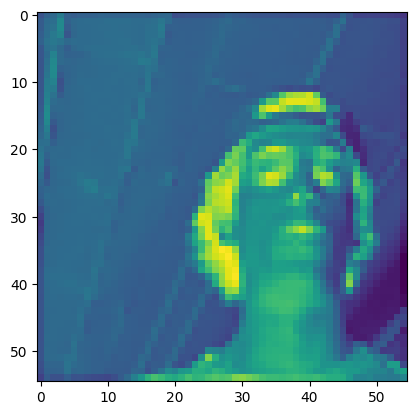

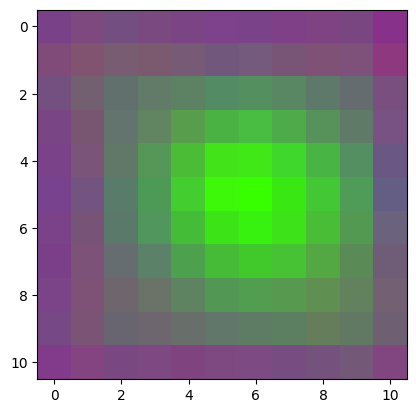

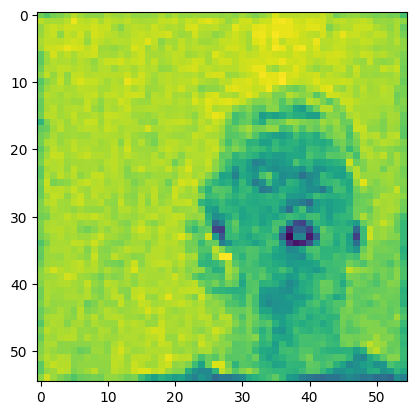

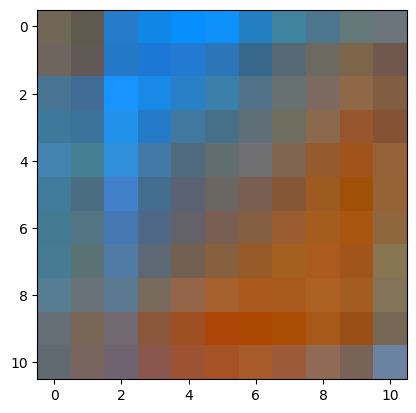

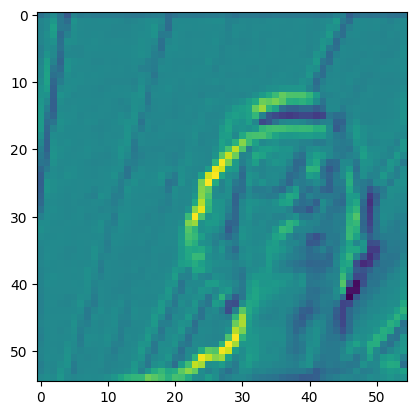

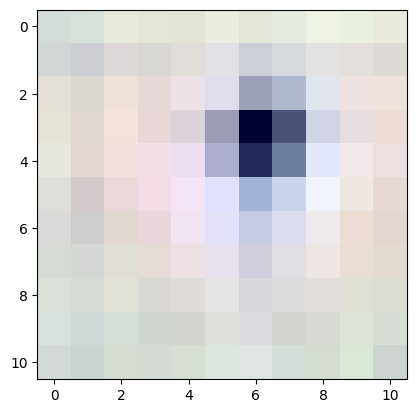

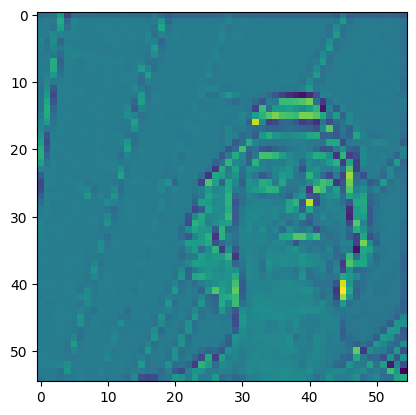

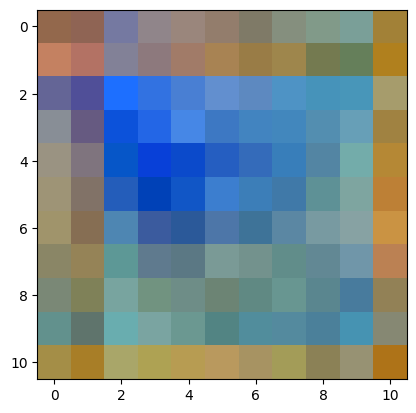

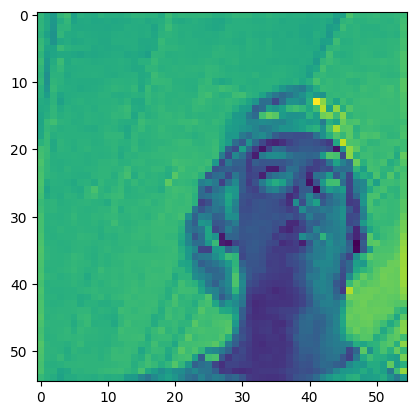

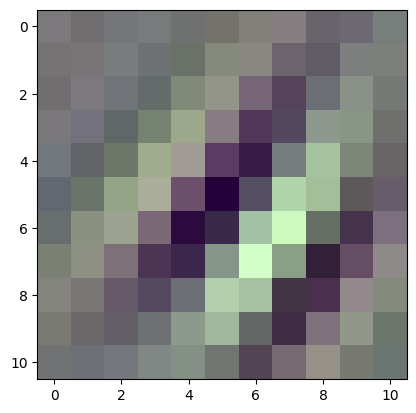

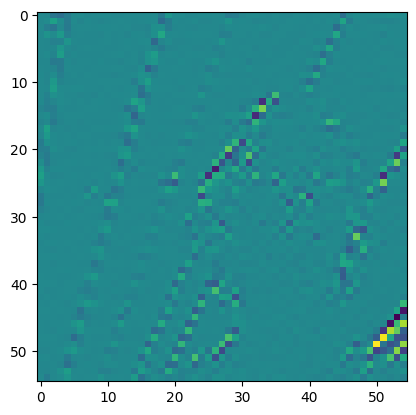

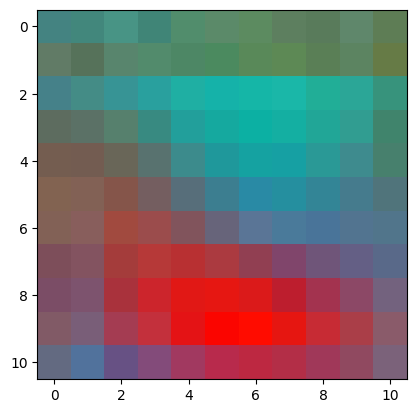

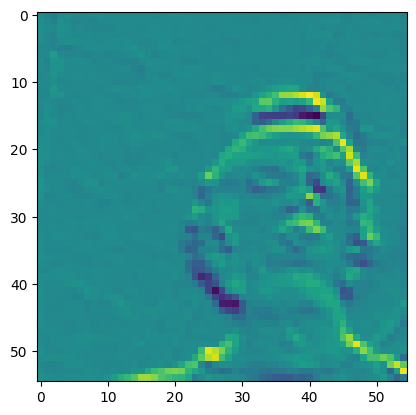

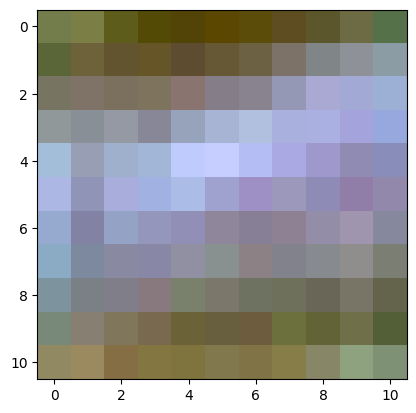

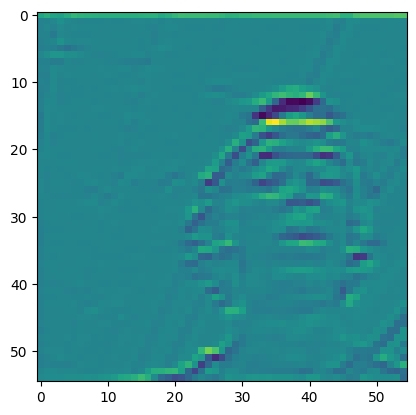

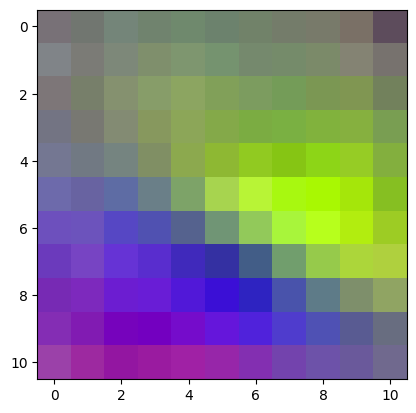

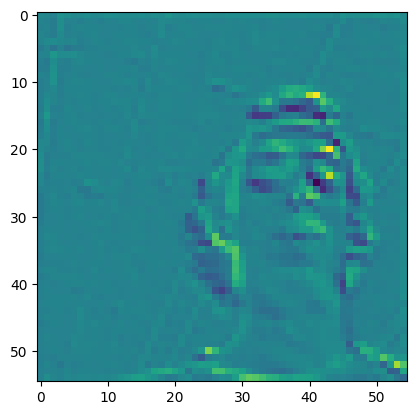

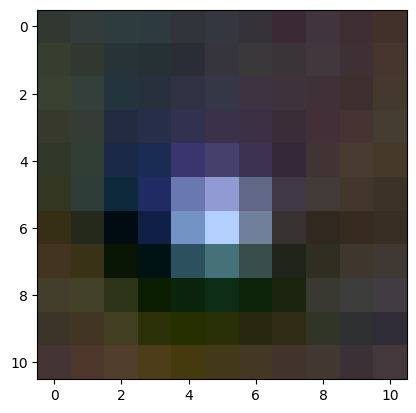

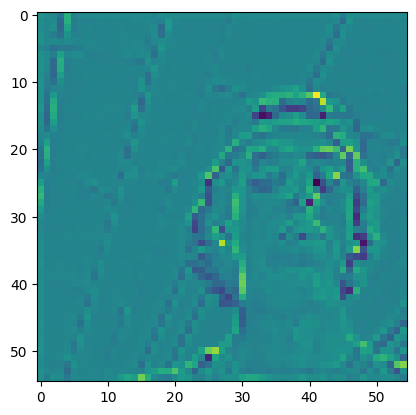

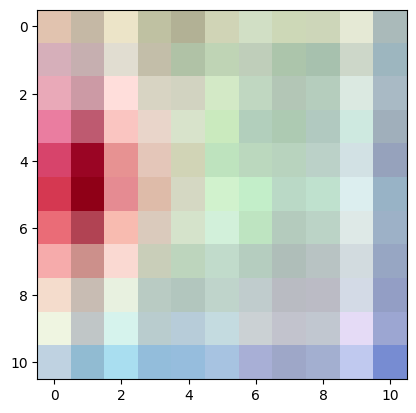

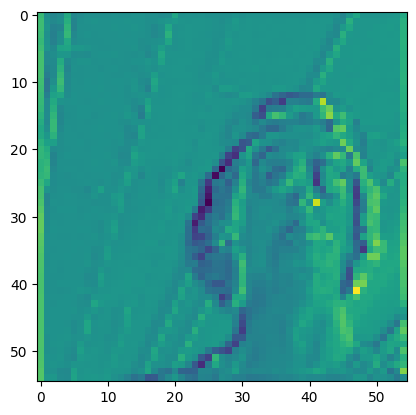

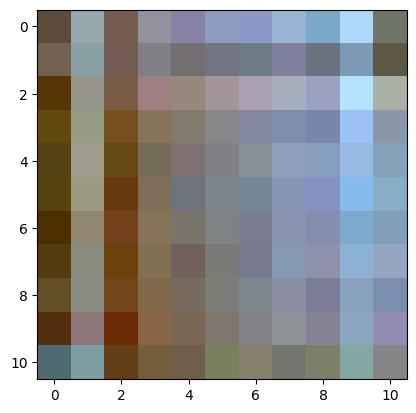

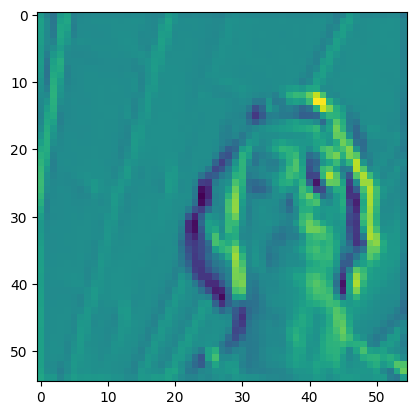

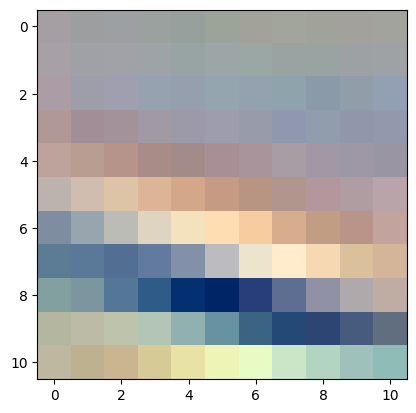

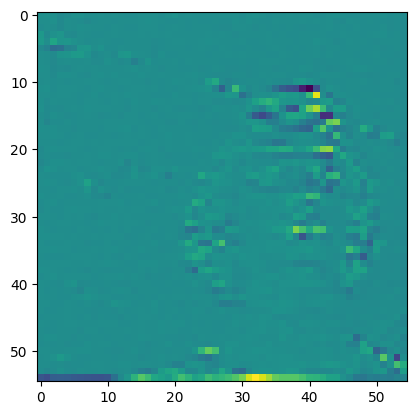

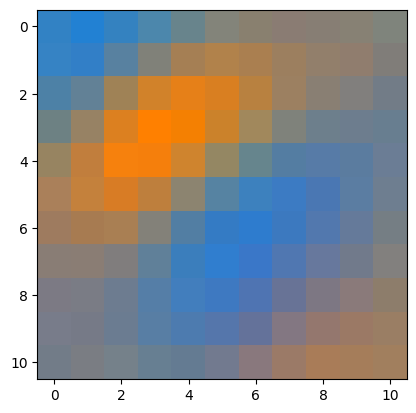

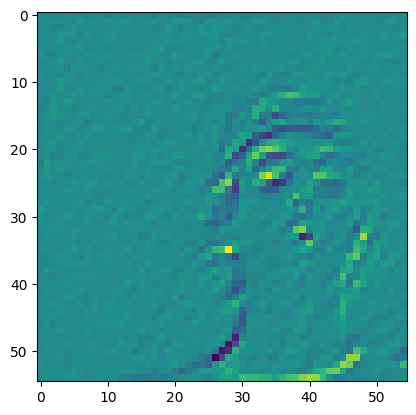

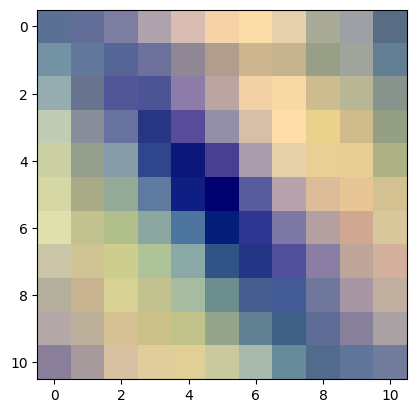

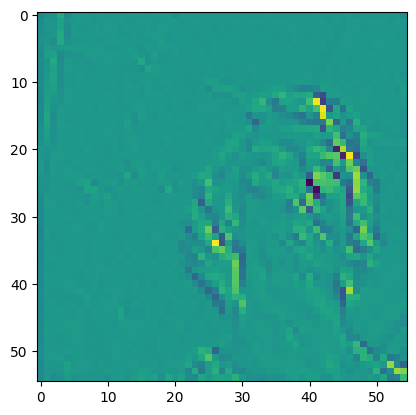

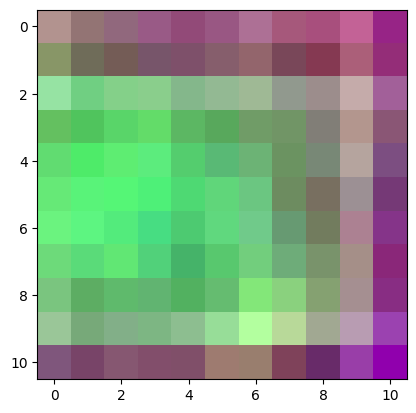

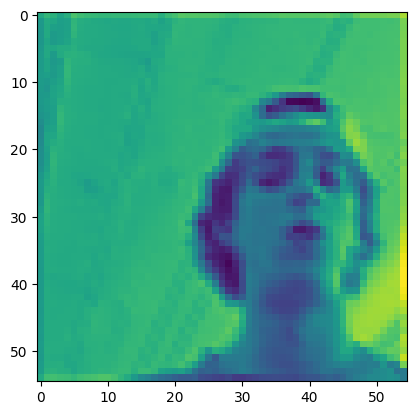

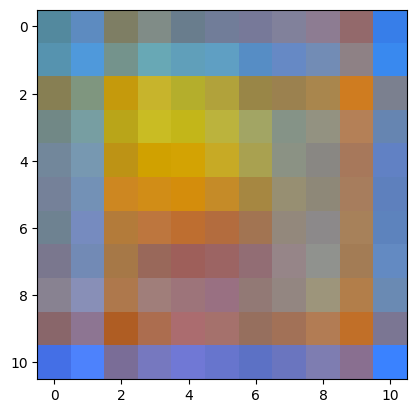

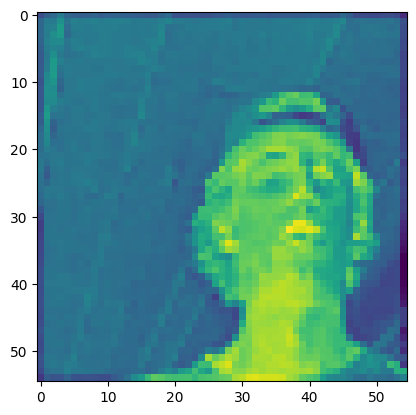

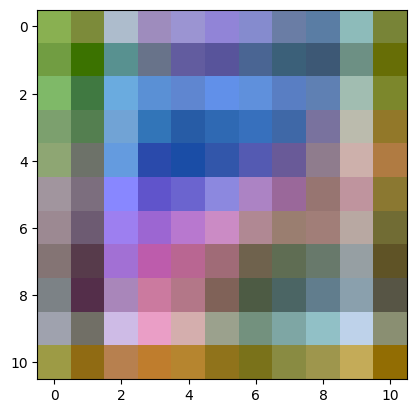

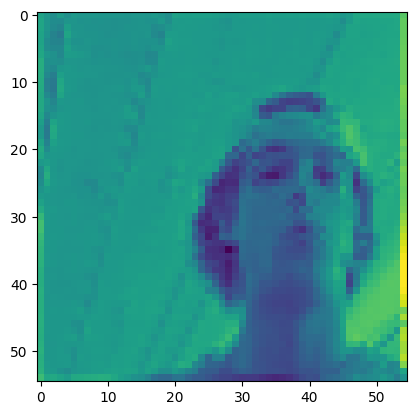

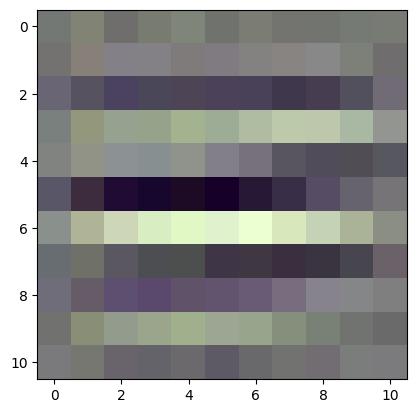

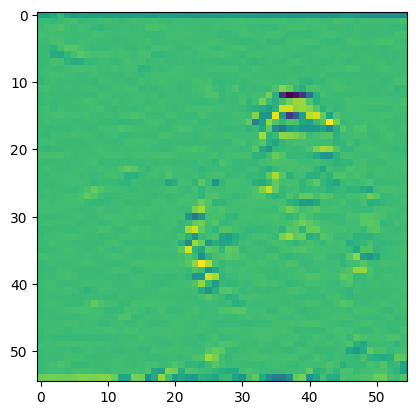

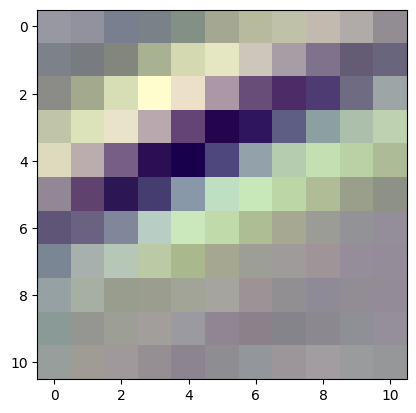

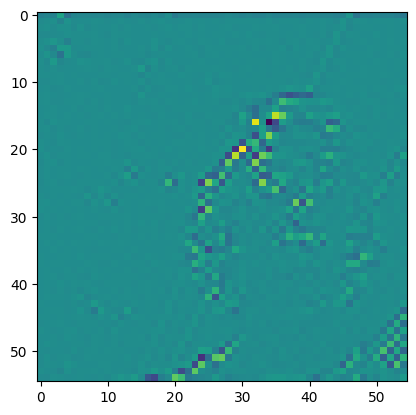

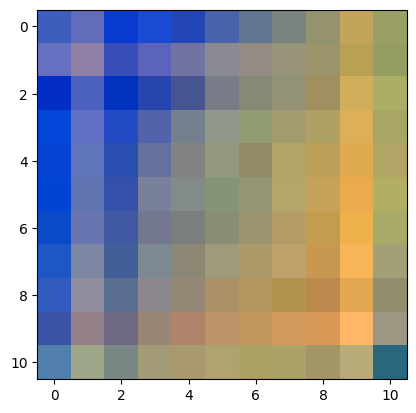

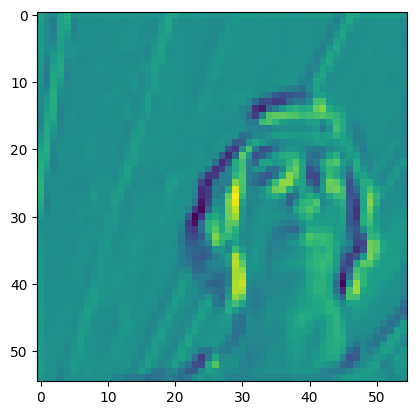

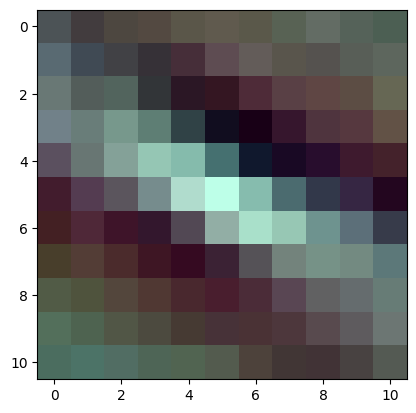

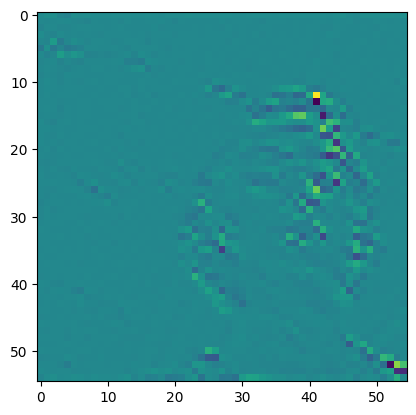

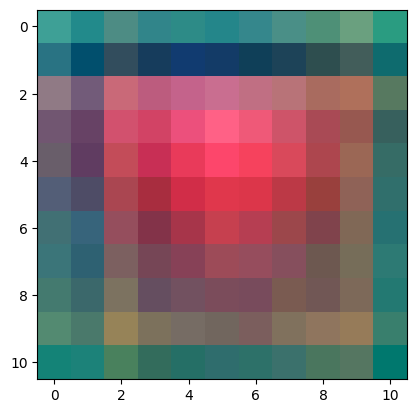

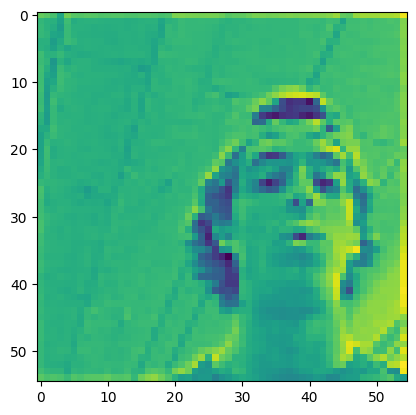

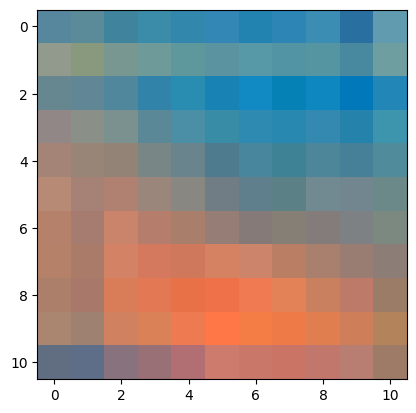

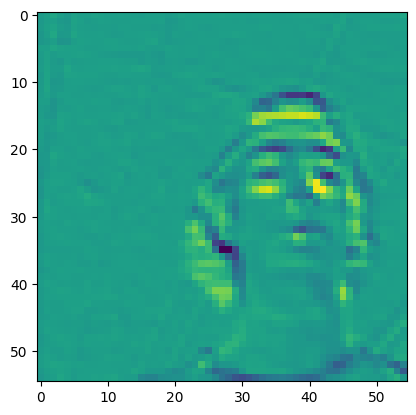

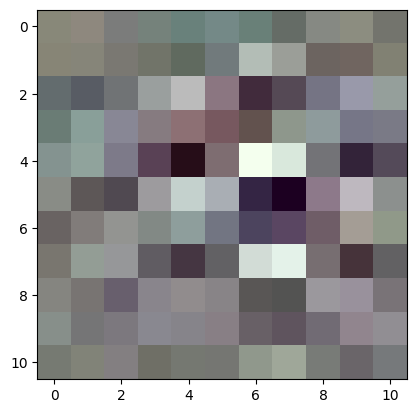

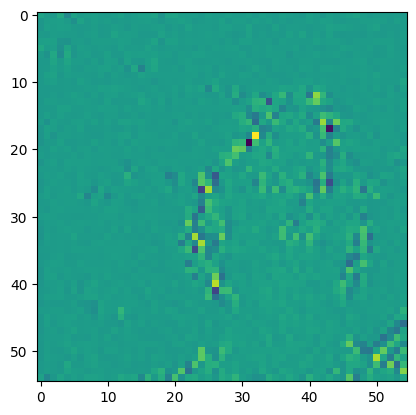

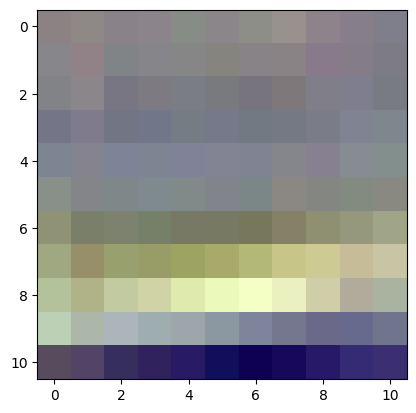

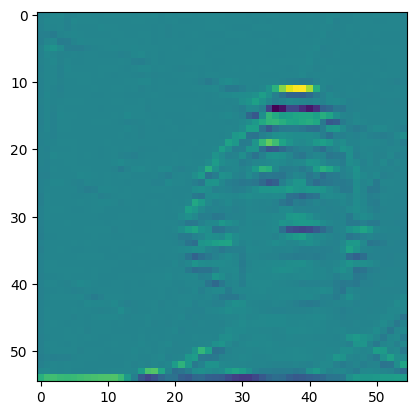

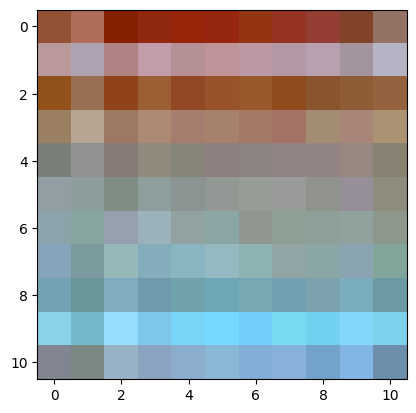

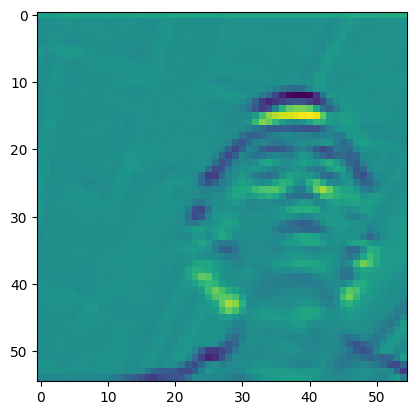

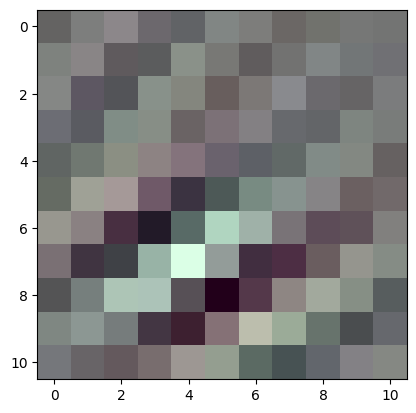

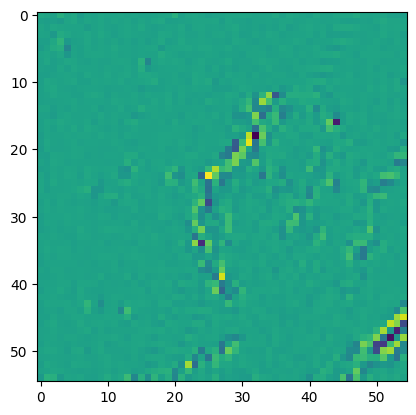

In [19]:
for i in range(64):
    tensor_plot(w0,i)
    plt.imshow(f0[0,i,:,:].cpu().numpy())
    plt.show()

In [20]:
import torch
import matplotlib.pyplot as plt

def plot_feature_maps_with_filters(feature_maps, filters):
    # Remove batch dimension if it exists
    if feature_maps.dim() == 4:
        feature_maps = feature_maps.squeeze(0)

    # Normalize feature maps to [0, 1]
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    def add_filter_to_feature_map(filter_tensor, feature_map_tensor):
        # Ensure the feature map is 2D [H, W]
        if feature_map_tensor.dim() > 2:
            feature_map_tensor = feature_map_tensor.squeeze(0)

        # Convert grayscale feature map to RGB by repeating the single channel 3 times
        feature_map_rgb = feature_map_tensor.unsqueeze(0).repeat((3, 1, 1))

        # Normalize the filter to [0, 1]
        filter_tensor = (filter_tensor - filter_tensor.min()) / (filter_tensor.max() - filter_tensor.min())

        # Ensure the filter fits into the feature map
        min_dim = min(feature_map_tensor.shape)
        filter_size = min(filter_tensor.shape[-1], min_dim)

        # Crop the filter if needed
        filter_cropped = filter_tensor[:, :filter_size, :filter_size]

        # Overlay the RGB filter at the lower-left corner of the feature map
        feature_map_rgb[:, -filter_size:, :filter_size] = filter_cropped

        # Clip the values to be in the range [0, 1]
        feature_map_rgb = torch.clamp(feature_map_rgb, 0, 1)

        return feature_map_rgb

    # Plot montage of feature maps
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))

    for ax, feature_map, filter_ in zip(axes.flat, feature_maps, filters):
        # Add RGB filter to grayscale feature map
        modified_feature_map = add_filter_to_feature_map(filter_, feature_map)

        # Plot modified feature map
        ax.imshow(modified_feature_map.permute(1, 2, 0).cpu().numpy(), interpolation='none')  # Added 'none' interpolation
        ax.axis('off')

    plt.show()

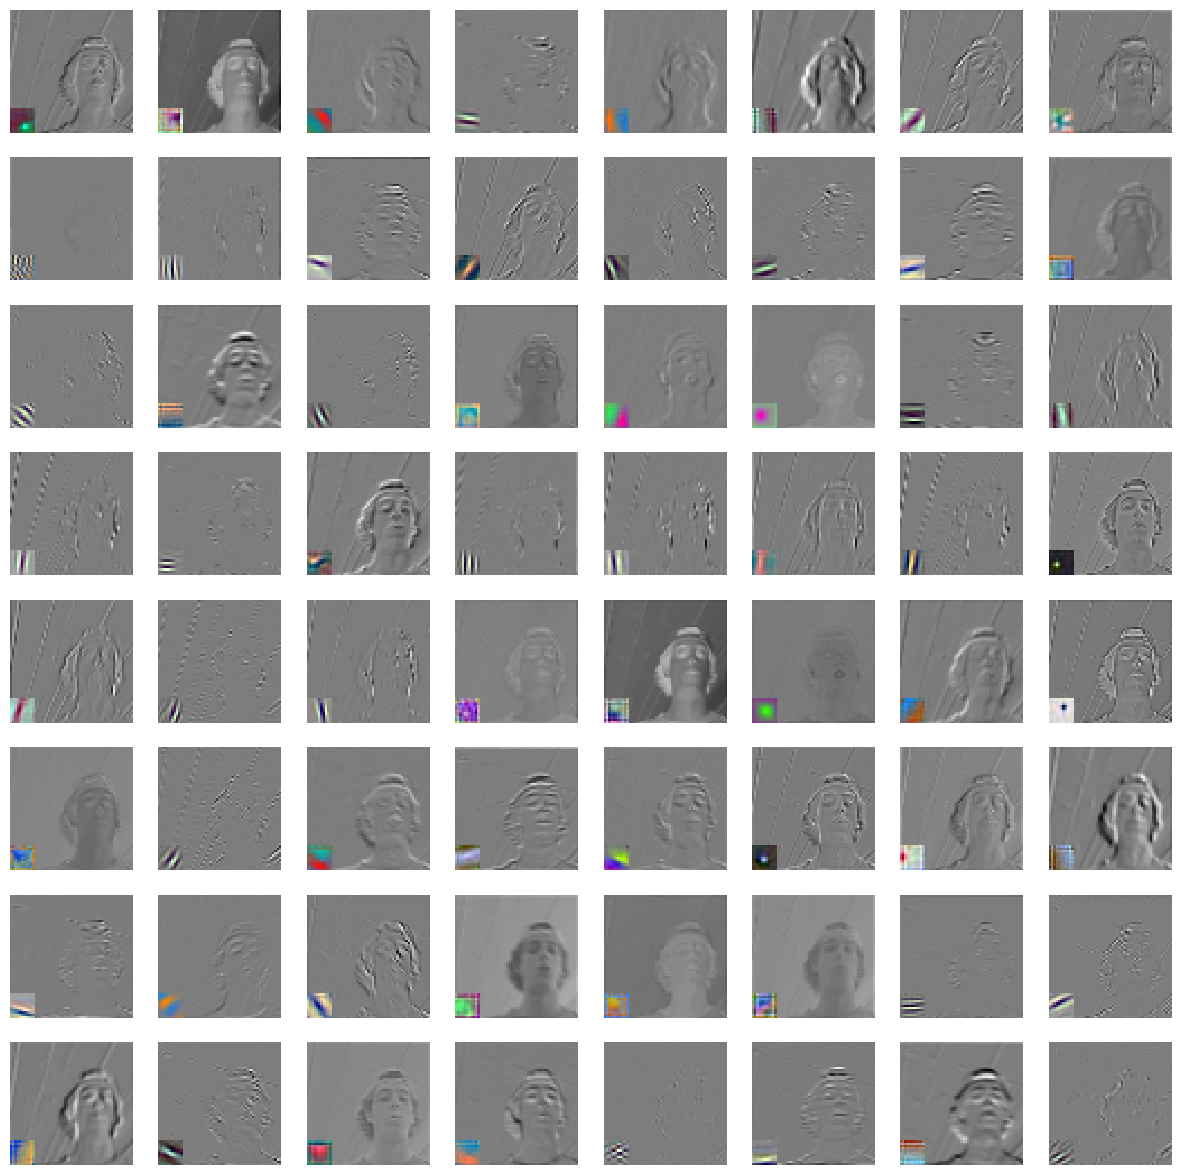

In [21]:
plot_feature_maps_with_filters(f0, w0)